# Проект о влиянии условий жизни учащихся на их успеваемость по математике

Начнем с загрузки нужных библитек и данных


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
sns.set()

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

math_data = pd.read_csv('stud_math.csv')  # импортируем данные

Цель проекта: подготовка данных для постороения модели предсказания результатов учащихся по математике

Предстоит выполение ряда этапов для достижения цели, а именно:
    
 * Посмотреть на данные.
 * Проверить данные на пустые значения.
 * Проверить данные на дублированные/полностью скоррелированные значения.
 * Проверить данные на наличие выбросов.
 * Отобрать данные, пригодные для дальнейшего построения модели.

## Описание датасета


Посмотрим на переменные, которые содержит датасет:

1 school — аббревиатура школы, в которой учится ученик ( 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)

2 sex — пол ученика ('F' - женский, 'M' - мужской)

3 age — возраст ученика (от 15 до 22)

4 address — тип адреса ученика ('U' - городской, 'R' - за городом)

5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)

6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

15 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

16 schoolsup — дополнительная образовательная поддержка (yes или no)

17 famsup — семейная образовательная поддержка (yes или no)

18 paid — дополнительные платные занятия по математике (yes или no)

19 activities — дополнительные внеучебные занятия (yes или no)

20 nursery — посещал детский сад (yes или no)

21 higher — хочет получить высшее образование (yes или no)

22 internet — наличие интернета дома (yes или no)

23 romantic — в романтических отношениях (yes или no)

24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

28 absences — количество пропущенных занятий

29 score — баллы по госэкзамену по математике

Из описания 29 признаков дата сета мы может сделать предположения о типе данных и их диапазоне. Бросается в глаза, что очень много бинарных принаков  - принимает только два значения ("да" - "нет", "городской" - "за городом", "мужской" - "женский"), а именно 13 из 29. Также много категориальных признаков, где значения распределены в диапазоне от 0 до 4 или от 1 до 5, 8 колонок из 29. Это может повлиять на выбор модели, а также на методы, которые мы будем использовать для анализа данных. 


## Предобработка 

In [101]:
def fix_empty_values(col):
    '''
        функция для нахождения пропусков в данных (пустая строка, строка со строковым значением 'nan'), 
        заменяет найденные значения на None
    '''

    return math_data[col].astype(str).apply(lambda x: None if (x.strip() == '' or x == 'nan') else x)


def binary_col_analysis(col):  # аргумент col - колонка для анализа
    '''
        функция для анализа колонок с номинативными переменными, 
        показывает основные статистические показатели, строит визуализацию .....
    '''
    # выводим общие сведения о колонке

    print('Колонка:', col)
    print('Уникальные значения:', math_data[col].unique())
    print('')
    print('Распределение значений:', pd.DataFrame(
        math_data[col].value_counts(dropna=False)))
    print('')
    print('Статистика колонки:', pd.DataFrame(math_data[col].describe()))

    # строим графики распределения значений в колонке (числа и проценты) и распределение относительно 'score'

    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle(
        'Распределение признака количественное, в процентах, относительно признака score')
    sns.countplot(ax=axes[0, 0], x=col, data=math_data)
    axes[0, 0].set_title('Количественное распределение признака')

    math_data[col].value_counts(normalize=True).plot(
        kind='barh', ax=axes[0, 1])
    axes[0, 1].set_title('Процентное распределение признака')

    sns.boxplot(ax=axes[1, 0], x=col, y='score', data=math_data)
    axes[1, 0].set_title('Бокс плот признака и score')

    sns.stripplot(ax=axes[1, 1], x=col, y='score', data=math_data)
    axes[1, 1].set_title('Распределение признака относительно score')
    plt.show()

    print('Cреднее распределение баллов относительно',
          math_data.groupby(col)['score'].mean())
    for val in math_data[col].unique():
        math_data[math_data[col] == val].score.hist(bins=20, alpha=0.5)
    plt.show()


def categorical_col_analysis(col):  # аргумент col - колонка для анализа
    '''
        функция для анализа колонок с номинативными переменными, 
        показывает основные статистические показатели, строит визуализацию .....
    '''
    # выводим общие сведения о колонке

    print('Колонка:', col)
    print('Уникальные значения:', math_data[col].unique())
    print('')
    print('Распределение значений:', pd.DataFrame(
        math_data[col].value_counts(dropna=False)))
    print('')
    print('Статистика колонки:', pd.DataFrame(math_data[col].describe()))

    # строим графики распределения значений в колонке (числа и проценты) и распределение относительно 'score'

    fig, axes = plt.subplots(1, 2, figsize=(25, 10))
    fig.suptitle(
        'Распределение признака количественное и относительно признака score')
    sns.countplot(ax=axes[0], x=col, data=math_data)
    # подписываем значения в процентах для распределения признака по категориям
    total = len(math_data[col])
    for p in axes[0].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        axes[0].annotate(percentage, (x, y))

    sns.boxplot(ax=axes[1], x=col, y='score', data=math_data)

    plt.show()


def numerical_col_analysis(col):
    '''
        функция для анализа колонок с числовыми переменными, 
        показывает основные статистические показатели, строит визуализацию .....
    '''
    # выводим общие сведения о колонке

    print('Колонка:', col)
    print('Уникальные значения:', math_data[col].unique())
    print('')
    print('Распределение значений:', pd.DataFrame(
        math_data[col].value_counts(dropna=False)))
    print('')
    print('Статистика колонки:', pd.DataFrame(math_data[col].describe()))

    # строим гистограмму распределения значений в колонке

    math_data[col].hist()
    plt.show()


def get_stat_dif(col):
    '''
        функция анализа значимости различий в колонке для номинативных признаков, с помощью теста Стьюдента
    '''
    cols = math_data.loc[:, col].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(math_data.loc[math_data.loc[:, col] == comb[0], 'score'],
                     math_data.loc[math_data.loc[:, col] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', col)
            break


def find_outliers(col):
    '''
        функция для нахождения выбросов в данных, 
        высчитывает на основе IQR  и выводит значения и их количество за пределами границ выбросов 
    '''
    IQR = math_data[col].quantile(0.75) - math_data[col].quantile(0.25)
    perc25 = math_data[col].quantile(0.25)
    perc75 = math_data[col].quantile(0.75)
    print(
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    math_data[col].loc[math_data[col].between(
        perc25 - 1.5*IQR,
        perc75 + 1.5*IQR)]
    print("За пределами границ значение:", math_data[col].loc[~math_data[col].between(
        perc25 - 1.5*IQR,
        perc75 + 1.5*IQR)].value_counts())
    return

# 1. Первичный осмотр данных

## 1.1 Общая информация о наборе данных средствами Питона

Ознакомимся с общей информацией о нашем дата сете.  Посмотрим первые и последние 20 строчек из него и информацию о том, какие у нас есть признаки-колонки, тип хранимых в них данных, есть ли незаполненные значения - пропуски в данных.

In [2]:
# выведем число строк и столбцов
print(
    f" В наборе данных находится {math_data.shape[0]} строк и {math_data.shape[1]} столбцов")

# выведем название колонок
print(f" В таблице имеются колонки:\n", math_data.columns)

 В наборе данных находится 395 строк и 30 столбцов
 В таблице имеются колонки:
 Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')


Мы обнаружили дополнительную колонку 'studytime, granular', которой нет в описании к дата сету. Рассмотрим ее позже.

In [3]:
math_data.head(20)  # выводит 20 первых значений на экран

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


In [4]:
math_data.tail(20)  # выводит 20 последних значений на экран

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
375,MS,F,18,R,GT3,T,1.0,1.0,other,other,home,mother,4.0,3.0,0.0,no,no,no,no,yes,-9.0,yes,yes,no,4.0,3.0,2.0,4.0,2.0,50.0
376,MS,F,20,NaN,GT3,T,4.0,2.0,health,other,course,NaN,2.0,3.0,2.0,no,yes,yes,no,no,-9.0,yes,yes,yes,5.0,4.0,3.0,3.0,4.0,75.0
377,MS,F,18,R,LE3,T,4.0,4.0,teacher,services,course,mother,1.0,2.0,0.0,no,no,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,3.0,2.0,4.0,50.0
378,MS,F,18,U,GT3,T,3.0,3.0,other,other,home,mother,1.0,2.0,0.0,no,no,yes,no,yes,-6.0,yes,yes,yes,4.0,1.0,3.0,1.0,0.0,75.0
379,MS,F,17,R,GT3,T,3.0,1.0,at_home,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,no,-6.0,yes,yes,no,4.0,5.0,4.0,1.0,17.0,50.0
380,MS,M,18,U,GT3,T,4.0,4.0,teacher,teacher,home,father,1.0,2.0,0.0,no,no,yes,yes,no,-6.0,yes,yes,NaN,3.0,2.0,4.0,2.0,4.0,70.0
381,MS,M,18,R,GT3,T,2.0,1.0,other,other,other,mother,2.0,1.0,0.0,no,no,no,yes,no,-3.0,yes,yes,yes,4.0,4.0,3.0,5.0,5.0,35.0
382,MS,M,17,U,GT3,T,2.0,3.0,other,services,NaN,father,2.0,2.0,0.0,no,no,no,yes,yes,-6.0,NaN,yes,no,4.0,4.0,3.0,3.0,2.0,50.0
383,MS,M,19,R,GT3,T,1.0,1.0,other,services,other,mother,2.0,1.0,1.0,no,no,no,no,NaN,-3.0,yes,no,no,4.0,3.0,2.0,5.0,0.0,0.0
384,MS,M,18,R,GT3,T,4.0,2.0,other,NaN,home,father,NaN,1.0,1.0,no,no,NaN,no,yes,-3.0,yes,NaN,no,5.0,4.0,3.0,3.0,14.0,25.0


In [5]:
math_data.sample(20)  # выводит 20 случайных значений на экран

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
163,GP,M,17,U,GT3,T,1.0,3.0,at_home,services,course,father,1.0,1.0,0.0,no,no,no,NaN,yes,-3.0,no,yes,no,5.0,3.0,3.0,2.0,2.0,50.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
270,GP,F,19,NaN,GT3,T,3.0,3.0,other,services,home,other,1.0,2.0,2.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,3.0,5.0,5.0,NaN,NaN
316,GP,F,18,U,GT3,T,2.0,1.0,services,NaN,course,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,3.0,3.0,1.0,0.0,0.0
302,GP,F,17,U,GT3,T,4.0,2.0,other,other,reputation,mother,2.0,3.0,0.0,no,NaN,yes,no,yes,-9.0,yes,yes,no,4.0,3.0,3.0,3.0,0.0,70.0
330,GP,M,18,U,LE3,T,2.0,2.0,other,other,course,mother,1.0,4.0,0.0,no,yes,no,yes,yes,-12.0,yes,yes,NaN,4.0,5.0,5.0,NaN,2.0,40.0
170,GP,M,16,U,GT3,T,3.0,4.0,other,other,course,father,3.0,1.0,NaN,no,yes,no,yes,no,-3.0,NaN,yes,no,3.0,4.0,5.0,2.0,0.0,0.0
152,GP,F,15,R,GT3,T,3.0,3.0,services,NaN,reputation,other,2.0,3.0,2.0,no,yes,yes,yes,NaN,-9.0,yes,yes,yes,4.0,2.0,1.0,3.0,8.0,50.0
15,GP,F,16,U,GT3,NaN,4.0,4.0,health,other,home,mother,1.0,1.0,0.0,no,yes,no,no,yes,-3.0,yes,yes,no,4.0,4.0,4.0,2.0,4.0,70.0
357,MS,F,17,U,LE3,NaN,3.0,2.0,services,other,reputation,mother,2.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,no,yes,1.0,2.0,3.0,5.0,2.0,55.0


При первичном осмотре данных мы видим значения, которыми они заполнены, и что в данных есть пропуски. А также можно предположить, что столбец 'studytime, granular' создан умножением столбца 'studytime' на константу -3.

In [6]:
math_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Итак, в наборе данных сведения о 395 учащихся, которые распределены между 30 колонками, описывающими этих учащихся. 13 столбцов имеют числовые значения (int64, float64) и 17 столбцов - строковые (object).

Однако, если внимательно изучить описание к дата сету, то получается, что у нас в таблице в столбцы с числовыми значениями попали ранговые (ординарные) данные: образование матери (Medu), образование отца (Fedu), время в пути до школы (traveltime), время на учёбу помимо школы в неделю (studytime), дополнительная колонка studytime, granular - полученная умножением колонки studytime на константу, семейные отношения (famrel), свободное время после школы (freetime), проведение времени с друзьями (goout), текущее состояние здоровья (health), количество внеучебных неудач (failures).

Числовыми данными заполнены только 3 колонки: возраст ученика(Age), количество пропущенных занятий (absences), баллы по госэкзамену по математике (score).

In [8]:
#  сохраним названия колонок для дальнейшего использования
math_cols = math_data.columns.tolist()
print(math_cols)

['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'studytime, granular', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'score']


Предложенным ниже способом мы не можем разделить колонки на числовые и нечисловые, так как в числовые попадут категориальные переменные тоже. К категориальным переменным мы должны применять другие методы (так вместо гистограммы нужно построить бар плот). Считаю нецелессобразным изменять тип переменных, так как для постороения модели все данные будут переводиться в числовые. Поэтому просто создадим списки для ординарных, бинарных и номинативных переменных. 

In [9]:
math_data_numeric = math_data.select_dtypes(include=[np.number])
numeric_cols = math_data_numeric.columns.values
print(numeric_cols)

math_data_non_numeric = math_data.select_dtypes(exclude=[np.number])
non_numeric_cols = math_data_non_numeric.columns.values
print(non_numeric_cols)

['age' 'Medu' 'Fedu' 'traveltime' 'studytime' 'failures'
 'studytime, granular' 'famrel' 'freetime' 'goout' 'health' 'absences'
 'score']
['school' 'sex' 'address' 'famsize' 'Pstatus' 'Mjob' 'Fjob' 'reason'
 'guardian' 'schoolsup' 'famsup' 'paid' 'activities' 'nursery' 'higher'
 'internet' 'romantic']


In [10]:
#  создадим лист с числовыми переменными
numeric_col = ['age', 'absences', 'score']

#  создадим лист с категориальными переменными
ordinal = ['Medu', 'Fedu', 'traveltime', 'studytime', 'studytime, granular',
           'failures', 'famrel', 'freetime', 'goout', 'health']

#  создадим лист с бинарными переменными
binary = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup',
          'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

#  создадим лист с номинативными переменными
nominal = ['Mjob', 'Fjob', 'reason', 'guardian']

# создадим объединенный список для категориальных и номинативных переменных
categorical = ['Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian',
               'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health']

Следует отметить, что составление таких списков не оптимизировано и в случае больших датасетов не рационально.

 ## 1.2 Пропуски в данных

Рассмотрим пропуски данных подробнее.

In [11]:
math_data.isna().sum().sort_values()

school                  0
sex                     0
age                     0
Medu                    3
score                   6
studytime, granular     7
studytime               7
goout                   8
schoolsup               9
freetime               11
absences               12
activities             14
health                 15
nursery                16
address                17
reason                 17
Mjob                   19
higher                 20
failures               22
Fedu                   24
famrel                 27
famsize                27
traveltime             28
guardian               31
romantic               31
internet               34
Fjob                   36
famsup                 39
paid                   40
Pstatus                45
dtype: int64

In [12]:
print('Процент пропусков: \n',  round(
    math_data.isna().sum().sort_values() / len(math_data) * 100, 3))

Процент пропусков: 
 school                  0.000
sex                     0.000
age                     0.000
Medu                    0.759
score                   1.519
studytime, granular     1.772
studytime               1.772
goout                   2.025
schoolsup               2.278
freetime                2.785
absences                3.038
activities              3.544
health                  3.797
nursery                 4.051
address                 4.304
reason                  4.304
Mjob                    4.810
higher                  5.063
failures                5.570
Fedu                    6.076
famrel                  6.835
famsize                 6.835
traveltime              7.089
guardian                7.848
romantic                7.848
internet                8.608
Fjob                    9.114
famsup                  9.873
paid                   10.127
Pstatus                11.392
dtype: float64


После применения функции isna() библиотеки Pandas больше всего пропусков обнаружено в колонках Pstatus, paid, famsup, Fjob  и internet в диапазоне от 34 до 45, что в целом составляет достаточно небольшой процент от общего количества данных по столбцам и не превышает 12%.

Построим диаграмму heatmap данных, чтобы на глаз оценить пропуски, воспользовавшись возможностями библиотеки Seaborn  

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')


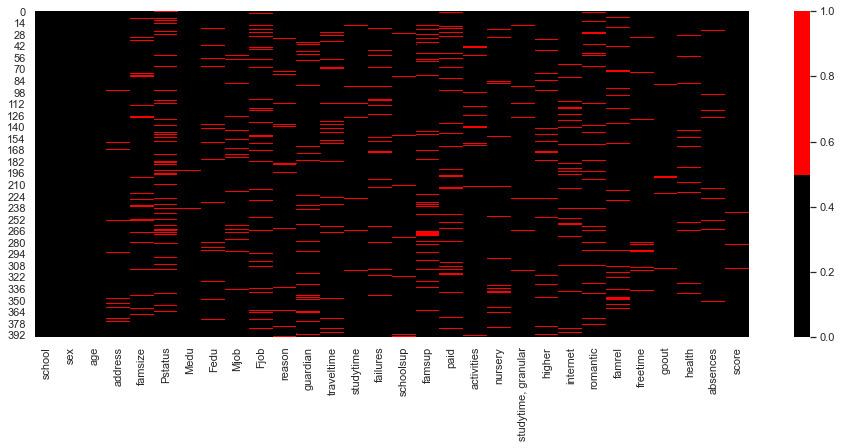

In [78]:
cols = math_data.columns
print(cols)
colours = ['black', 'red']
plt.figure(figsize=(16, 6))
sns.heatmap(math_data.isnull(), cmap=sns.color_palette(colours))

Проверим есть ли дубликаты строк

In [14]:
math_data.duplicated().sum()

0

Как мы видим дубликаты строк не обнаружены

Можно так же проверить, если есть пустые значения, которые просто заполнены, например, пустой строкой и не могли быть учтены с помощью функции isna() 

In [89]:
for col in math_cols:
    fix_empty_values(col)

После примения fix_empty_values, другие пустые значения не обнаружены.

Однако мы не можем пока предположить, что делать с пропущенными данными: отбросить(удалить) или заполнить, и если заполнить, то чем(каким значением)? Попробуем ответить на этот вопрос при более детальном рассмотрении колонок и распределении данных в них. 

## 1.3 Общая статистическая информация

In [15]:
math_data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


В этой таблице мы можем видеть такие показатели для числовых данных, как количество (количество непустых), среднее значение, стандартное отклонение  максимум, минимум, квартили(25% и 75%) и медиану (50%). 

Так в колонке возраст среднее значение приблизительно 16,7 лет, минимум 15 лет, а максимум 22 года. Эти значения попадают в заданный диапазон (range). 

Также можно заметить, что минимальное значение в колонке famrel семейные отношения равно -1, что выходит за заданные рамки от 1 до 5. Максимальное значение образования отца (Fedu) равно 40, что также не соответствует заданному диапазону. Странным выглядит максимально значение пропусков (absences) - 385, при том, что среднее значение составляет примерно 7,279, а медиана и верхний квартиль 4 и 8 соответственно.

In [16]:
# статистические данные для категориальных признаков
math_data.describe(include='O')

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,378,368,350,376,359,378,364,386,356,355,381,379,375,361,364
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,295,261,314,133,197,137,250,335,219,200,195,300,356,305,240


Здесь представлены статистические характеристики для нечисловых переменных типа object, такие как количество ненулевых значений, количество уникальных значений, самое часто встречающееся значение и частота этого значения.

Исходя из этой таблицы, мы можем сделать вывод, что большинство данных имеют бинарный тип и при необходимости могут быть приведены в типу boolean.

Большинство детей в нашем дата сете посещают школу GP (349 - почти все), проживают в городе ( 295 U - urban), ходили в детский сад (300) и хотят продолжить обучение после окончания школы (356), имеют дома доступ к интернету (305) и не получают дополнительной образовательной поддержки в школе (335). Также большинство родителей этих детей проживают совместно (314).

# 2. Pаспределение признака в колонках

Рассмотрим распределение признака в колонках, какие значения принимает переменная и построим соответствующие графики. Для этого воспользуемся функциями из предобработки. Мы проведем такой анализ для разных категорий данных отдельно.

## 2.1 Бинарные признаки

Рассмотрим бинарные признаки, у которых могут быть только два значения и которые являются частным случаем категориальных признаков.

Колонка: school
Уникальные значения: ['GP' 'MS']

Распределение значений:     school
GP     349
MS      46

Статистика колонки:        school
count     395
unique      2
top        GP
freq      349


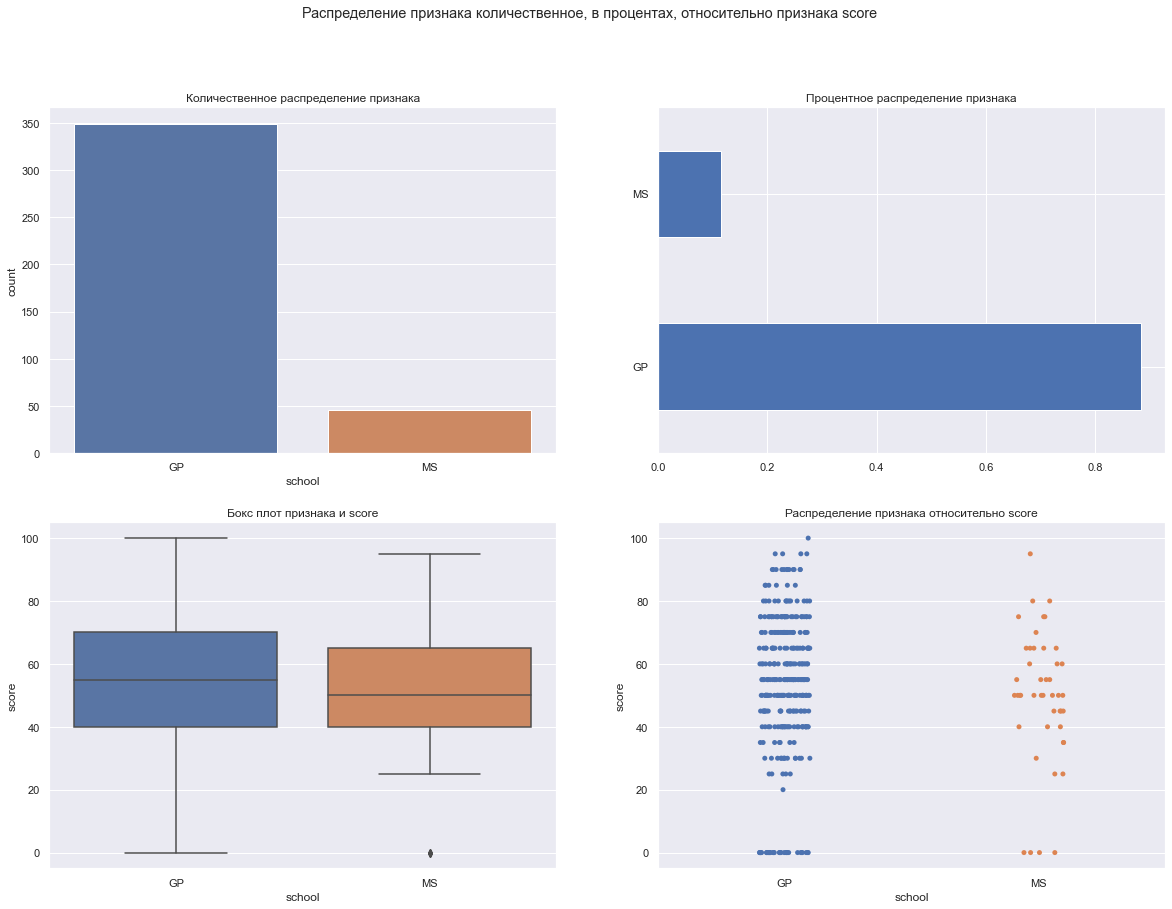

Cреднее распределение баллов относительно school
GP    52.630814
MS    49.444444
Name: score, dtype: float64


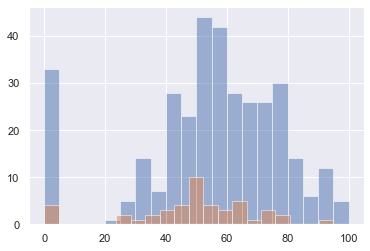



Колонка: sex
Уникальные значения: ['F' 'M']

Распределение значений:    sex
F  208
M  187

Статистика колонки:         sex
count   395
unique    2
top       F
freq    208


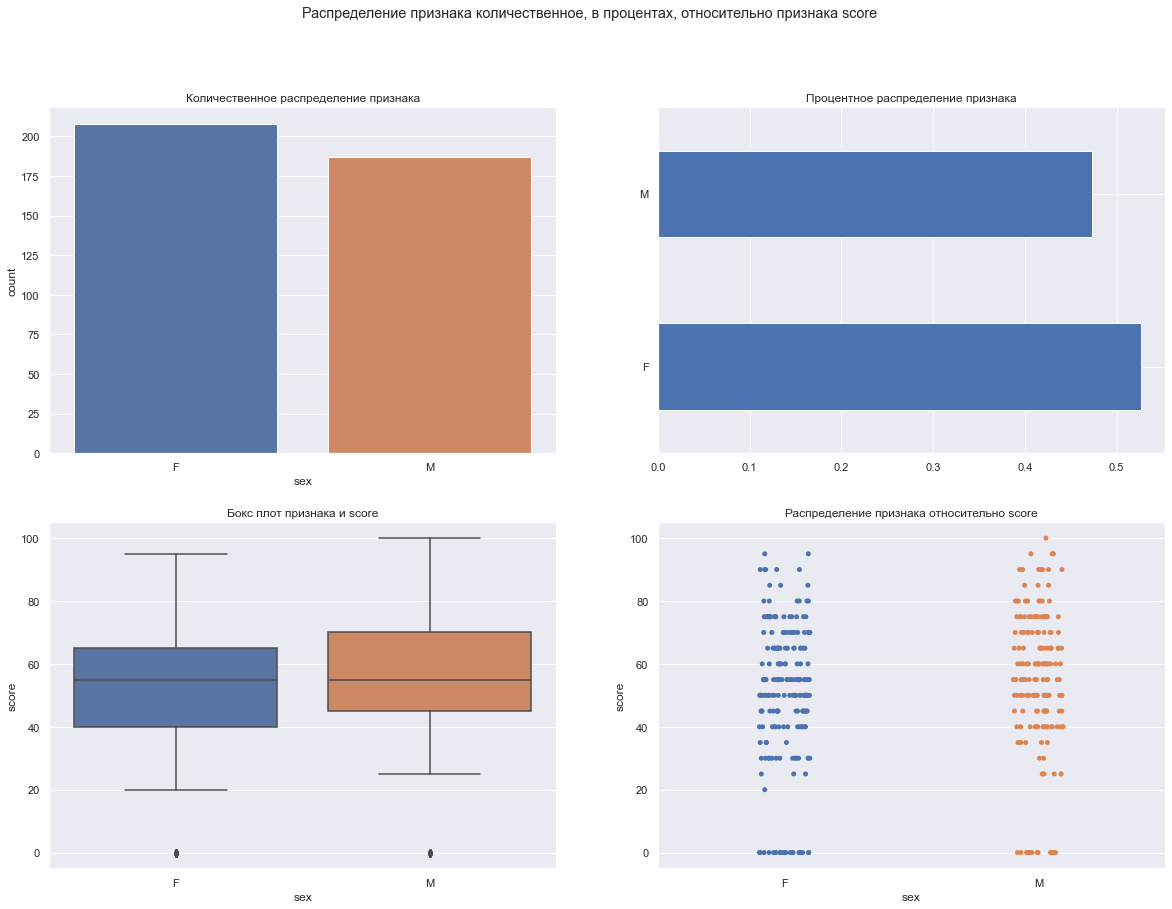

Cреднее распределение баллов относительно sex
F    50.098039
M    54.648649
Name: score, dtype: float64


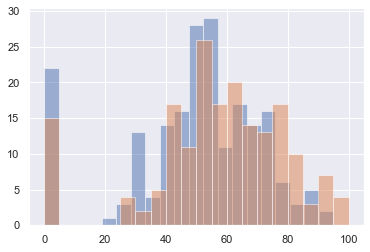



Колонка: address
Уникальные значения: ['U' nan 'R']

Распределение значений:      address
U        295
R         83
NaN       17

Статистика колонки:        address
count      378
unique       2
top          U
freq       295


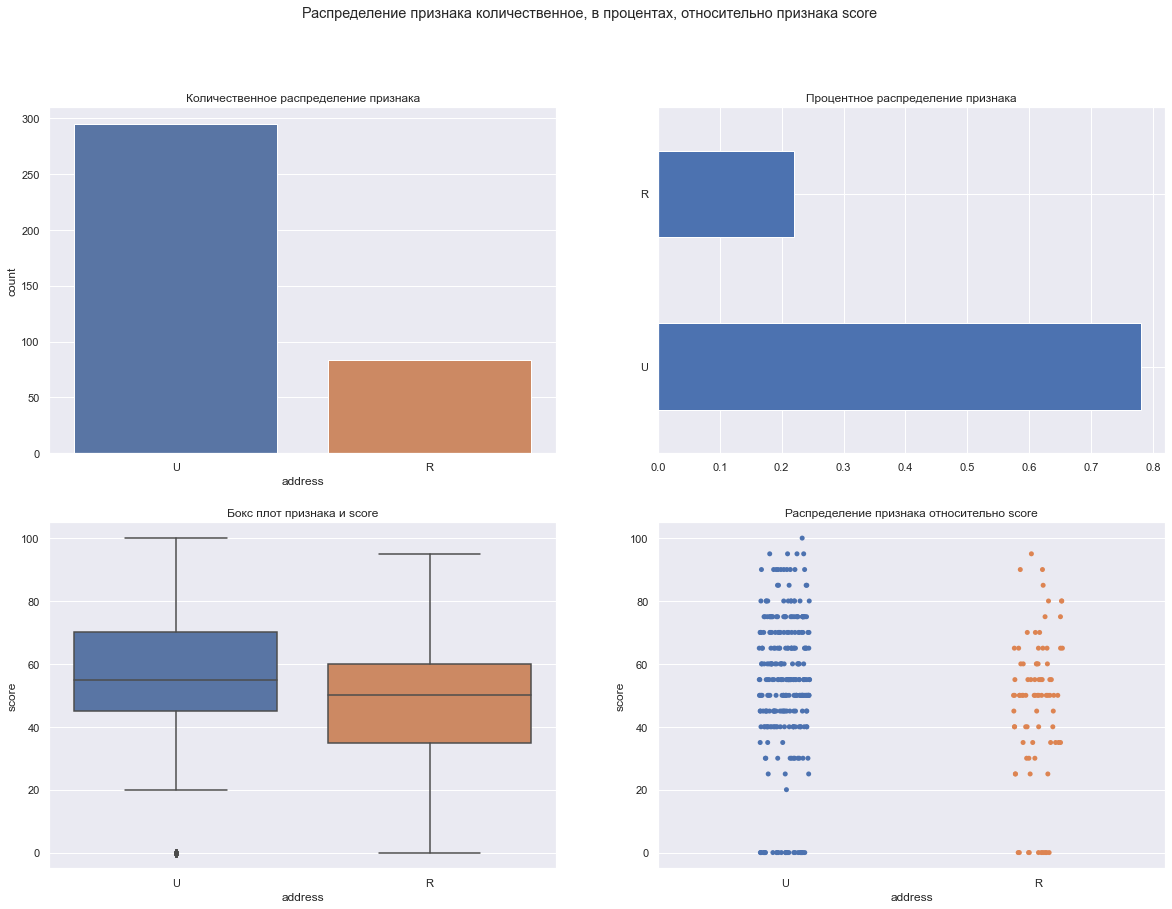

Cреднее распределение баллов относительно address
R    46.927711
U    53.573883
Name: score, dtype: float64


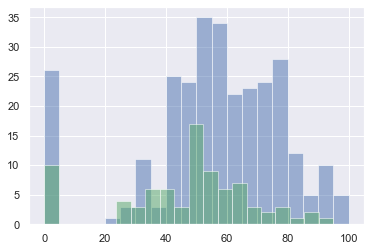



Колонка: famsize
Уникальные значения: [nan 'GT3' 'LE3']

Распределение значений:      famsize
GT3      261
LE3      107
NaN       27

Статистика колонки:        famsize
count      368
unique       2
top        GT3
freq       261


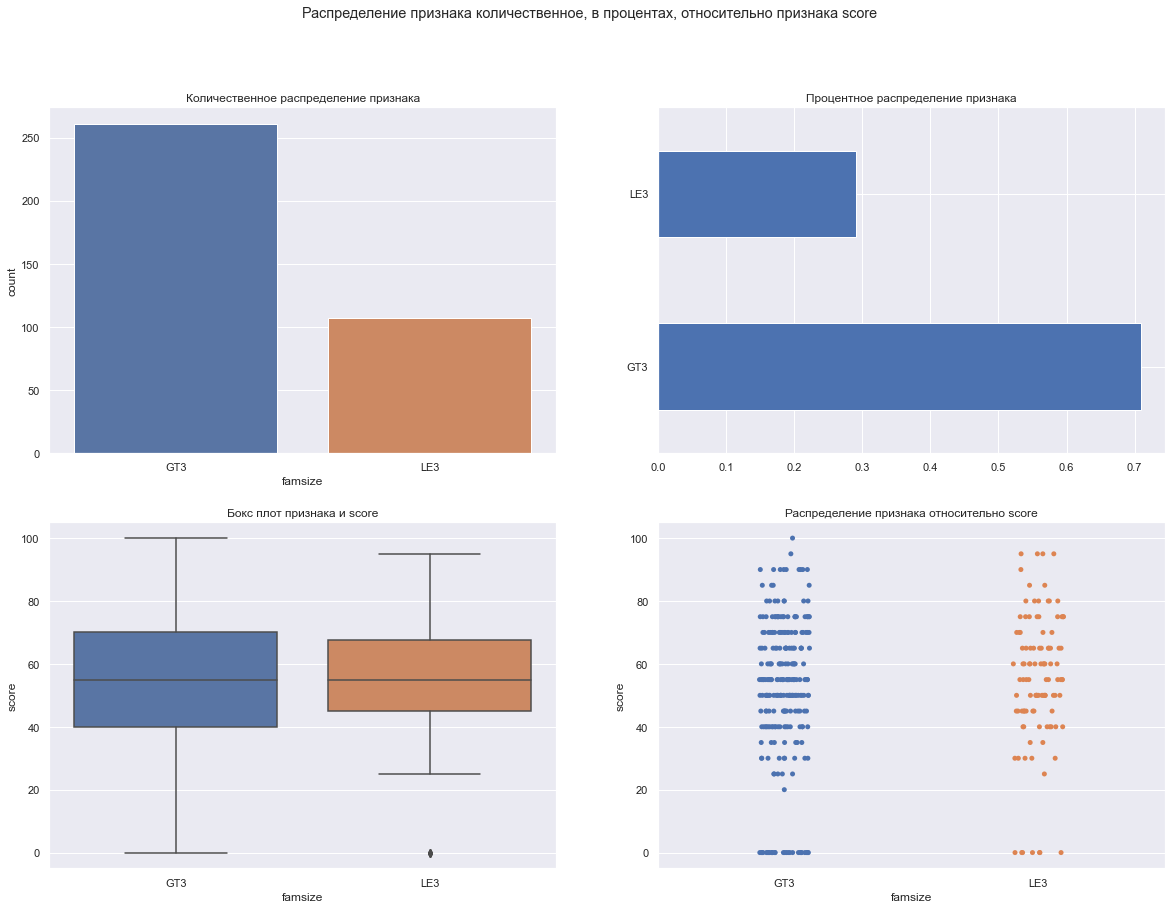

Cреднее распределение баллов относительно famsize
GT3    51.509804
LE3    54.672897
Name: score, dtype: float64


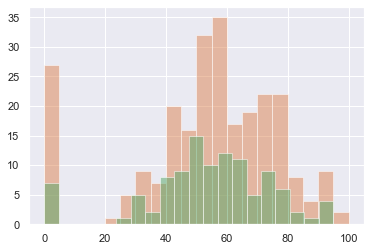



Колонка: Pstatus
Уникальные значения: ['A' nan 'T']

Распределение значений:      Pstatus
T        314
NaN       45
A         36

Статистика колонки:        Pstatus
count      350
unique       2
top          T
freq       314


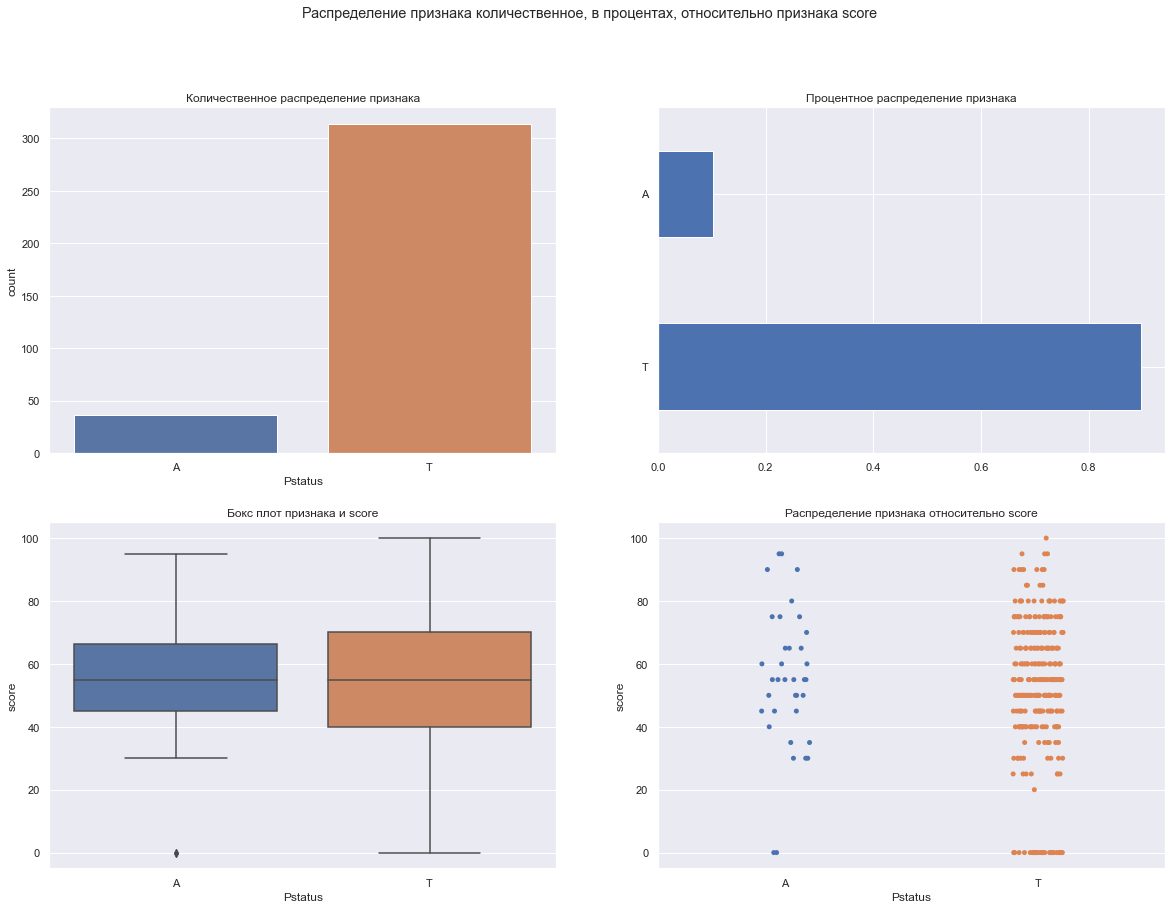

Cреднее распределение баллов относительно Pstatus
A    55.138889
T    51.704545
Name: score, dtype: float64


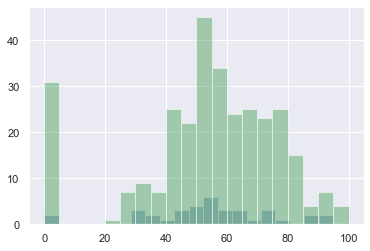



Колонка: schoolsup
Уникальные значения: ['yes' 'no' nan]

Распределение значений:      schoolsup
no         335
yes         51
NaN          9

Статистика колонки:        schoolsup
count        386
unique         2
top           no
freq         335


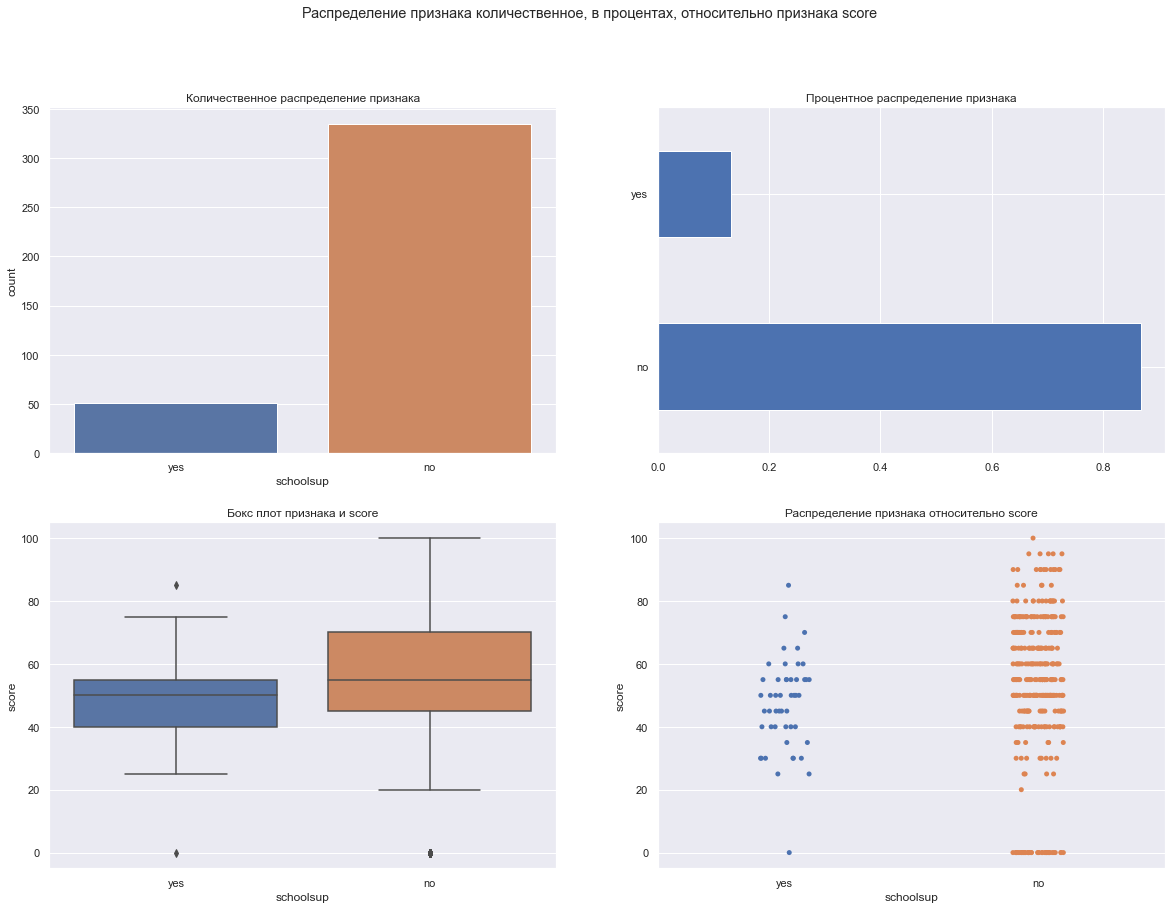

Cреднее распределение баллов относительно schoolsup
no     53.126888
yes    47.040816
Name: score, dtype: float64


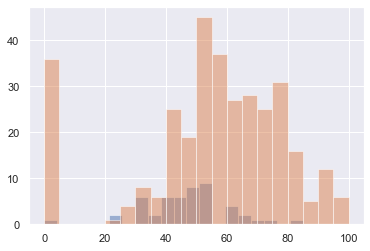



Колонка: famsup
Уникальные значения: ['no' 'yes' nan]

Распределение значений:      famsup
yes     219
no      137
NaN      39

Статистика колонки:        famsup
count     356
unique      2
top       yes
freq      219


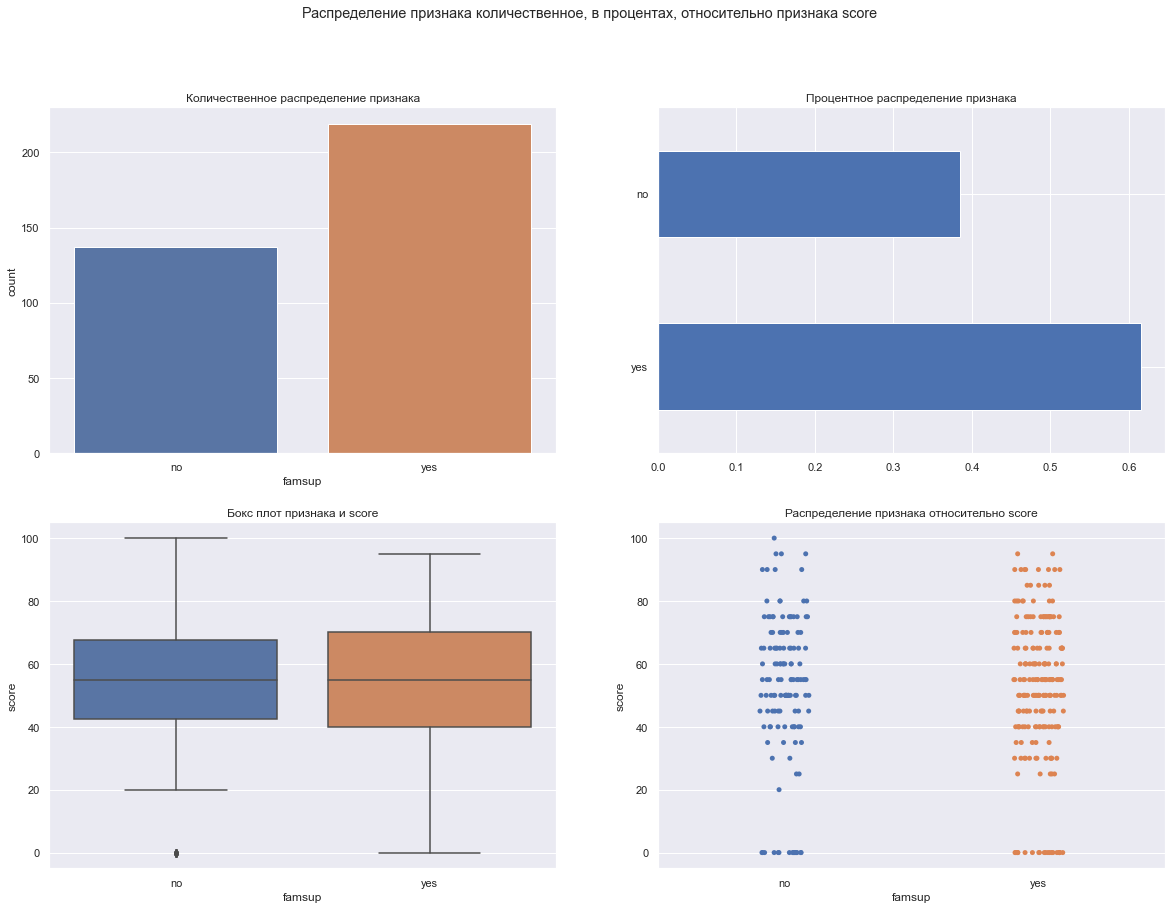

Cреднее распределение баллов относительно famsup
no     52.074074
yes    51.712963
Name: score, dtype: float64


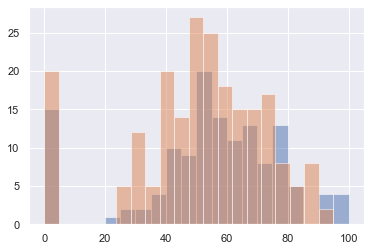



Колонка: paid
Уникальные значения: ['no' nan 'yes']

Распределение значений:      paid
no    200
yes   155
NaN    40

Статистика колонки:        paid
count   355
unique    2
top      no
freq    200


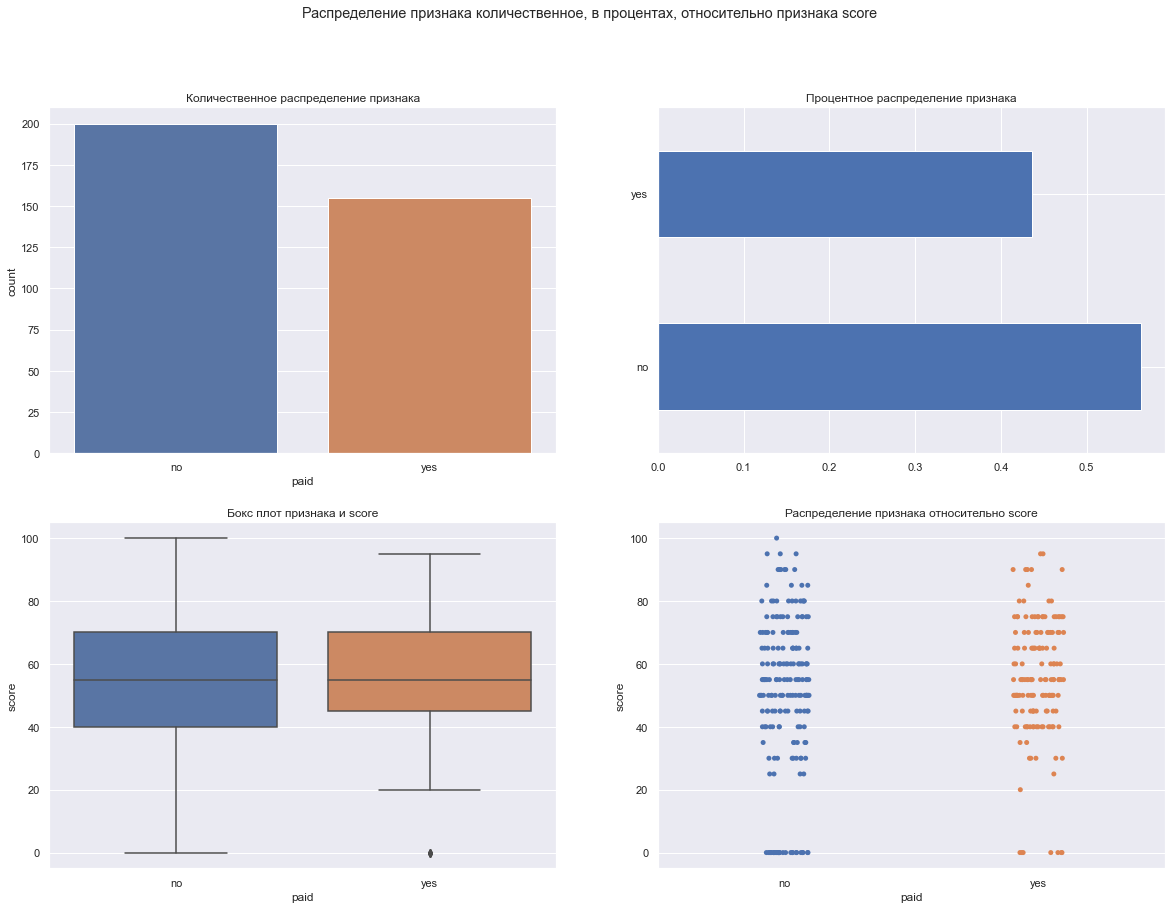

Cреднее распределение баллов относительно paid
no     50.35533
yes    55.00000
Name: score, dtype: float64


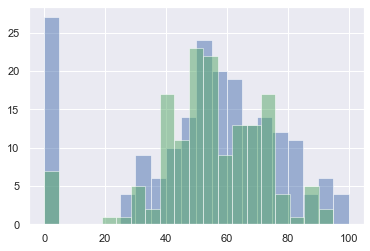



Колонка: activities
Уникальные значения: ['no' 'yes' nan]

Распределение значений:      activities
yes         195
no          186
NaN          14

Статистика колонки:        activities
count         381
unique          2
top           yes
freq          195


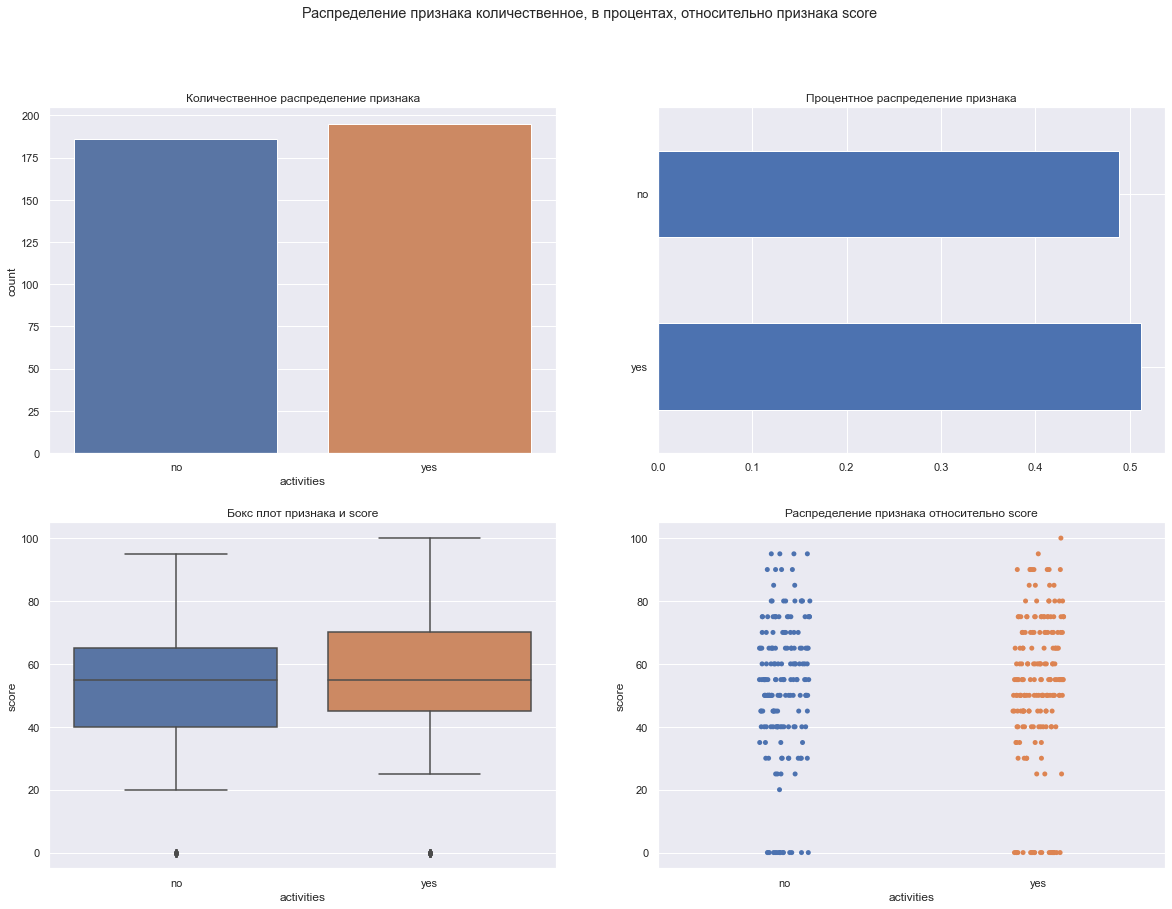

Cреднее распределение баллов относительно activities
no     52.185792
yes    52.682292
Name: score, dtype: float64


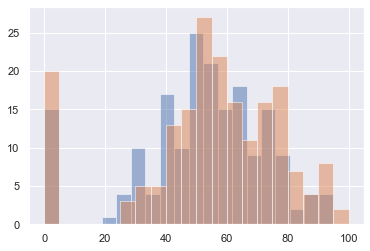



Колонка: nursery
Уникальные значения: ['yes' 'no' nan]

Распределение значений:      nursery
yes      300
no        79
NaN       16

Статистика колонки:        nursery
count      379
unique       2
top        yes
freq       300


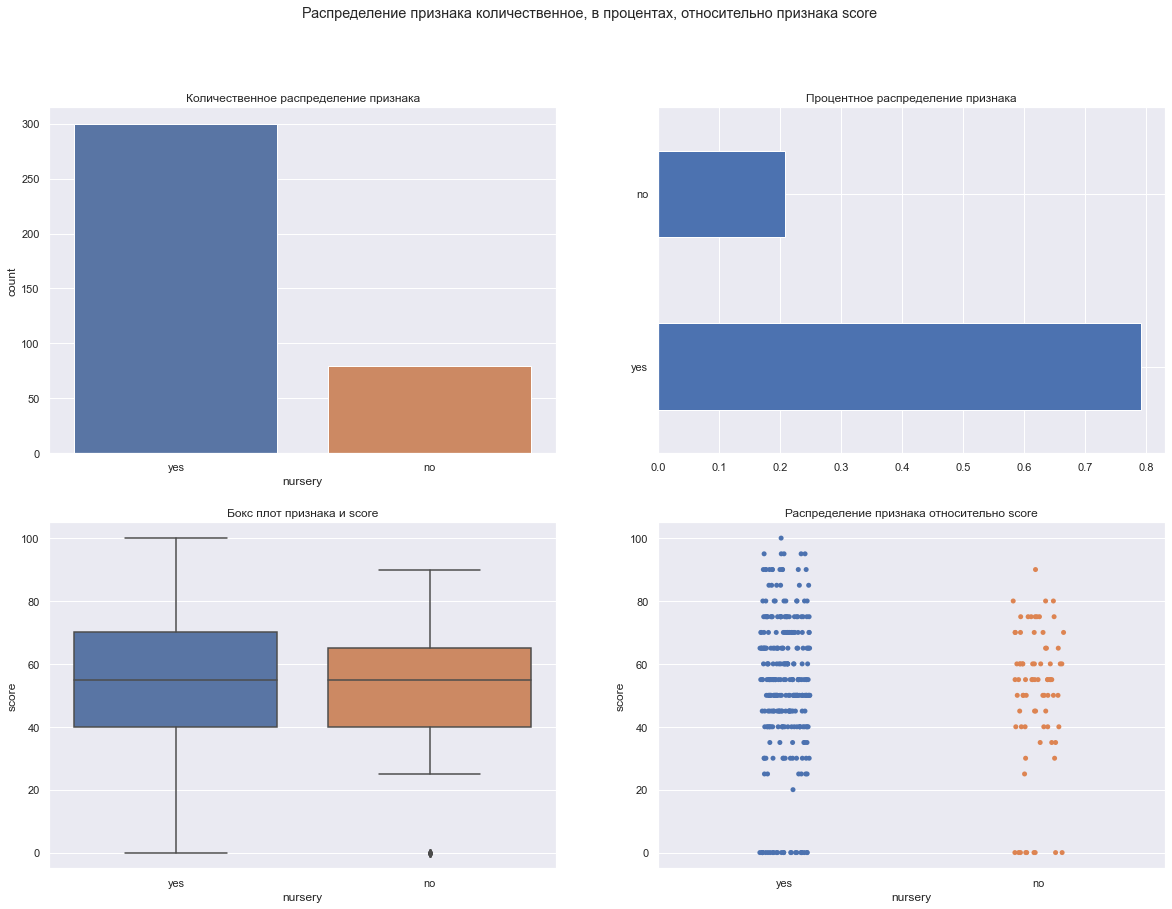

Cреднее распределение баллов относительно nursery
no     50.000000
yes    52.962963
Name: score, dtype: float64


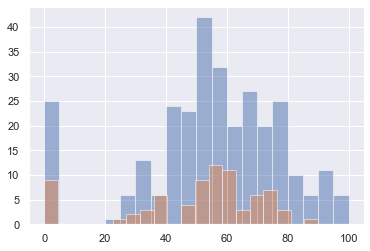



Колонка: higher
Уникальные значения: ['yes' nan 'no']

Распределение значений:      higher
yes     356
NaN      20
no       19

Статистика колонки:        higher
count     375
unique      2
top       yes
freq      356


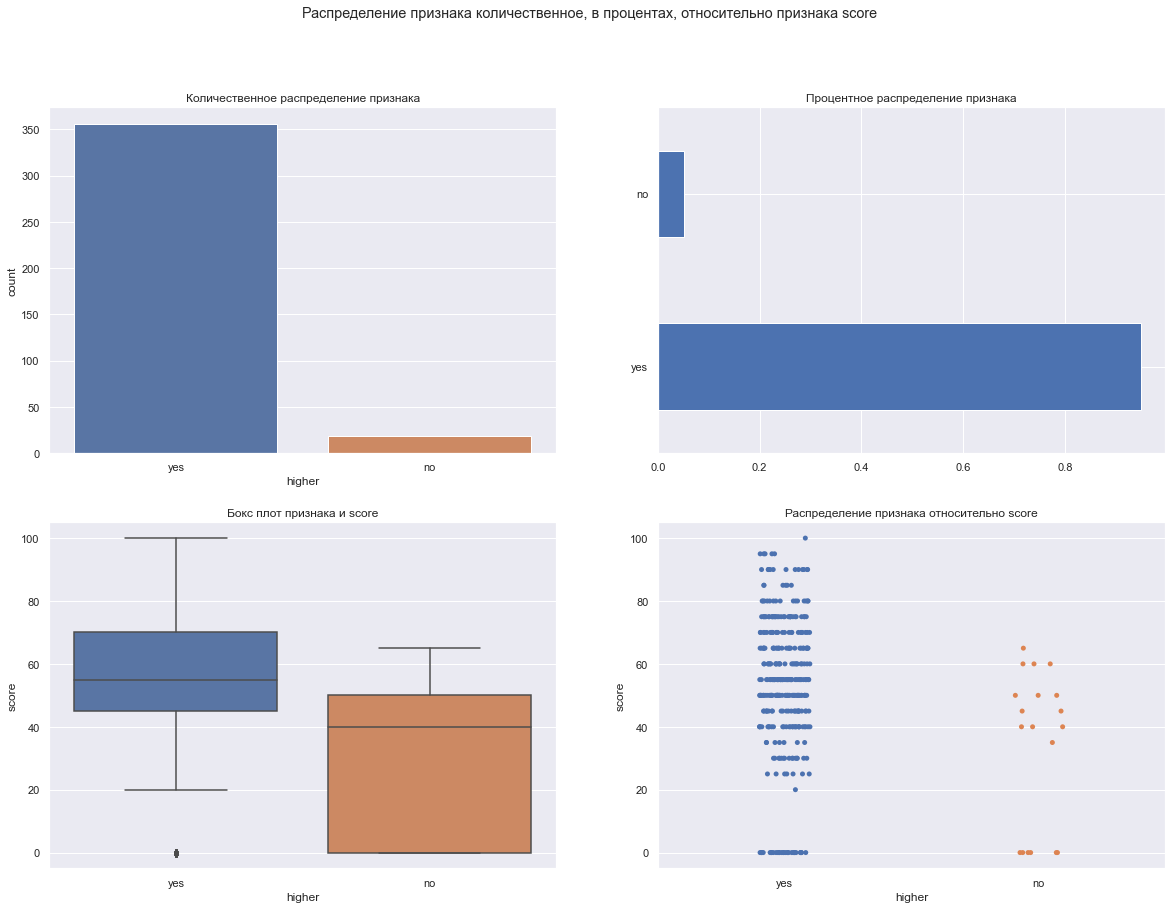

Cреднее распределение баллов относительно higher
no     33.684211
yes    53.100000
Name: score, dtype: float64


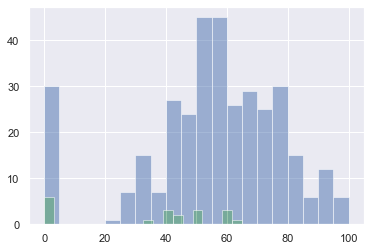



Колонка: internet
Уникальные значения: [nan 'yes' 'no']

Распределение значений:      internet
yes       305
no         56
NaN        34

Статистика колонки:        internet
count       361
unique        2
top         yes
freq        305


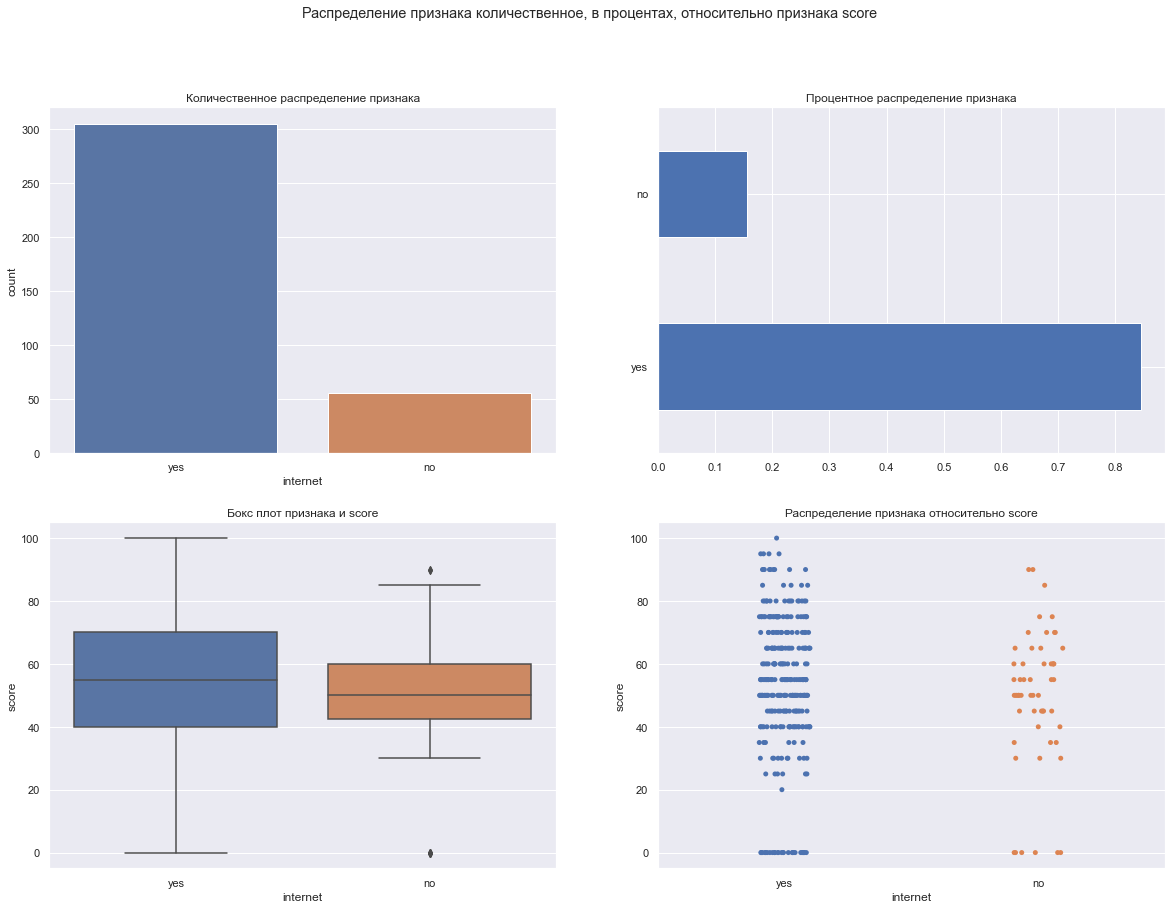

Cреднее распределение баллов относительно internet
no     49.090909
yes    53.116667
Name: score, dtype: float64


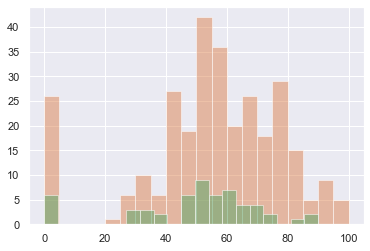



Колонка: romantic
Уникальные значения: ['no' nan 'yes']

Распределение значений:      romantic
no        240
yes       124
NaN        31

Статистика колонки:        romantic
count       364
unique        2
top          no
freq        240


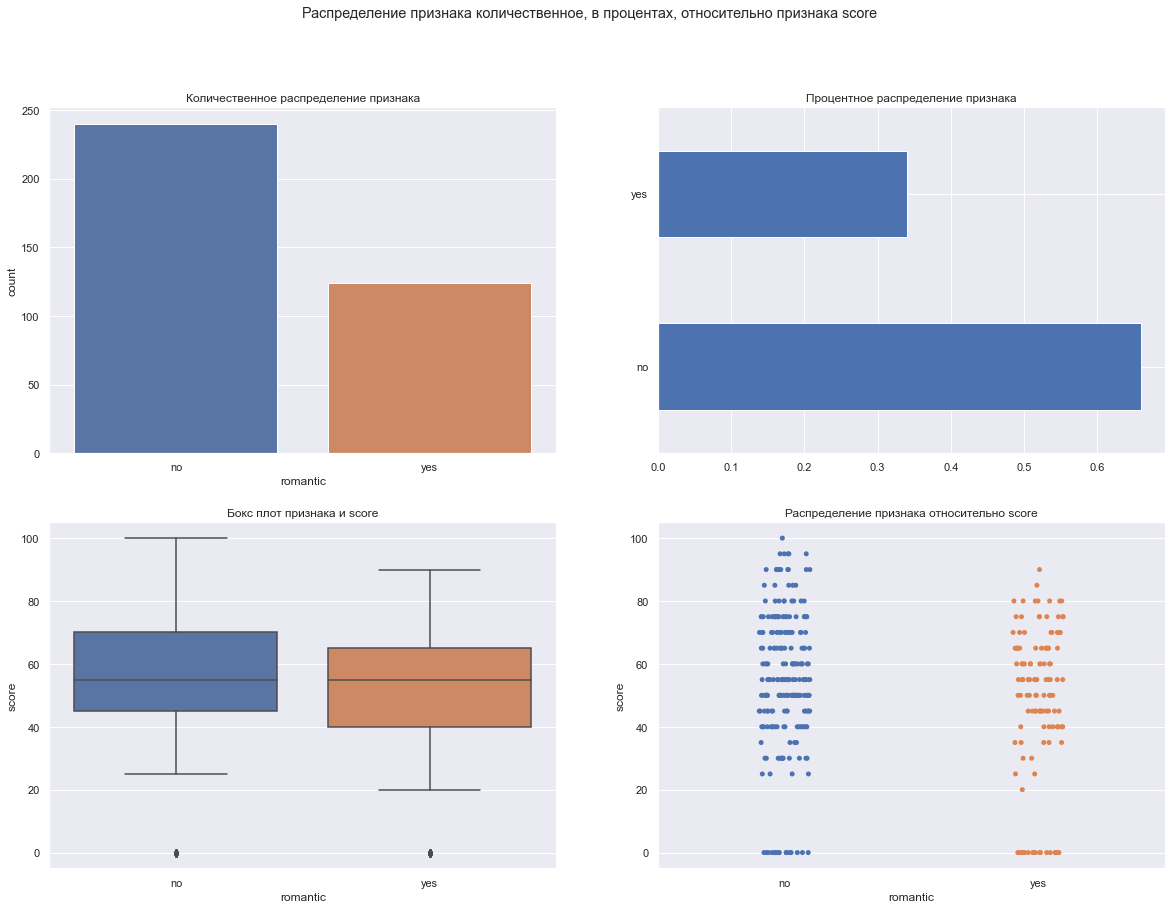

Cреднее распределение баллов относительно romantic
no     54.574468
yes    47.682927
Name: score, dtype: float64


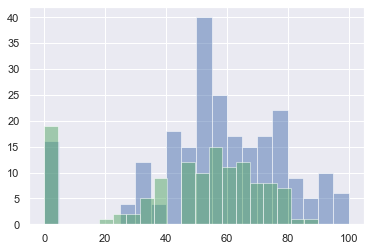

In [19]:
for columns in binary:              # задаем цикл для бинарных переменных
    # вызываем функцию для обработки бинарных переменных
    binary_col_analysis(columns)
    print('')
    print('')

###### Вывод по колонке school
Более 80% детей обучаются в школе 'GP'. Их результаты по математике в среднем выше на 3 процента. Больше детей в  этой школе достигли балл выше, чем у школы 'MS' (распределения похожи по форме, но у 'MS' значения смещены влево). С другой стороны в школе 'MS' низкие результаты начинаются примерно с 25. В школе 'GP' больше нулевых значений. В школе 'MS' тоже есть нулевые значения, показаны как выброс на боксплоте. Пропусков в признаке нет. Значения в пределах описанного диапазона('GP' или 'MS').

###### Вывод по колонке sex
По полу- девочек в наборе данных больше (> 50 %), мальчиков чуть меньше. Мальчики сдавали экзамен в целом лучше. Средний балл по экзамену 50 и 54,6 для девочек и мальчиков соответственно. Пропусков в признаке нет. Значения в пределах описанного диапазона('M', 'F')

###### Вывод по колонке address
Чуть менее 80% детей проживает в городе и около 20 процентов детей проживает за городской чертой (в регионе). Относительно баллов, дети, проживающие в городе, сдали экзамен заметно лучше, это хорошо видно по боксплоту ниже(особенно если мы еще добавим в распределение школы). 
Средний балл городских детей на 7 баллов больше. В этой колонке 17 пропусков. При заполнении пропущенных данных можно использовать моду или вручную: если пропуск адреса для школы GP, то он заполнится значением U, а для MS - R. Значения в пределах описанного диапазона ( 'U', 'R')

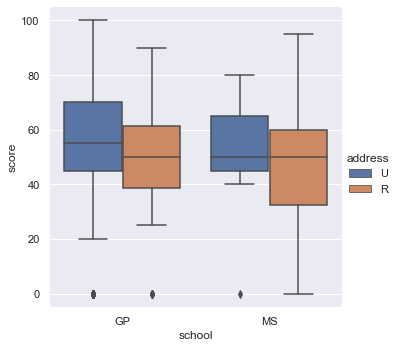

In [20]:
sns.catplot(x='school', y='score', hue='address', kind='box', data=math_data)

###### Вывод по колонке famsize
В семьях, где 3 и менее членов семьи проживают около 30 % детей и 70% процентов проживают в семьях, где больше 3 человек. Значимых различий в результатах экзамена для семей, где один ребенок и много, не наблюдается. В колонке 27 пропусков. Ниже представлена таблица пропусков и распределение по признакам 'address', 'Pstatus', 'Medu'. По данным статистики средний размер семьи - 2,6, однако в региональной Португалии, где проживает бОльшее количество католических семей, размер семьи больше (https://www.pordata.pt/en/Portugal/Average+household+size++according+to+the+Census-908). Предлагаю заполнить для региональной Португалии пропуски значением 'GT3'. Для разведенных семей заполнить также, кроме семей для женщин с уровнем убразования 4. Принимаемые значения в пределах описанного диапазона. 

In [21]:
# данные по пропускам в колонке famsize
nan_rows = math_data[math_data['famsize'].isnull()]
nan_rows

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0
32,GP,M,15,R,NaN,T,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,no,yes,no,yes,NaN,-6.0,yes,yes,yes,4.0,NaN,2.0,5.0,0.0,80.0
36,GP,M,15,U,NaN,T,4.0,3.0,teacher,services,home,mother,1.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,4.0,3.0,4.0,2.0,90.0
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
78,GP,M,17,U,NaN,T,2.0,1.0,other,other,home,mother,2.0,1.0,3.0,yes,NaN,no,yes,yes,-3.0,no,yes,no,4.0,5.0,1.0,3.0,2.0,50.0
79,GP,F,16,U,NaN,T,3.0,4.0,at_home,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,-6.0,yes,yes,no,2.0,4.0,3.0,3.0,12.0,25.0
114,GP,M,15,R,NaN,T,2.0,1.0,health,services,reputation,mother,1.0,2.0,NaN,no,no,no,yes,yes,-6.0,yes,yes,yes,5.0,4.0,2.0,5.0,8.0,45.0
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,-3.0,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0


In [22]:
math_data.groupby(['address', 'Pstatus', 'Medu'])['famsize'].value_counts()

address  Pstatus  Medu  famsize
R        A        3.0   GT3         3
                  4.0   GT3         1
         T        1.0   GT3        12
                        LE3         4
                  2.0   GT3        16
                        LE3         3
                  3.0   GT3        13
                        LE3         5
                  4.0   GT3         9
                        LE3         3
U        A        2.0   GT3         5
                        LE3         1
                  3.0   GT3         7
                        LE3         4
                  4.0   LE3         6
                        GT3         4
         T        0.0   GT3         2
                        LE3         1
                  1.0   GT3        16
                        LE3        14
                  2.0   GT3        36
                        LE3        16
                  3.0   GT3        39
                        LE3         8
                  4.0   GT3        61
                  

In [ ]:
math_data.loc[((math_data['famsize'].isnull()) & (
    math_data['address'] == 'R')), 'famsize'] = 'GT3'  # заполнить пропуски по условию

###### Вывод по колонке Pstatus
Более 90% семей проживают совместно. Эта колонка с самым большим количеством пропусков, около 12%. При заполнении их модой пропуски примут значения 'T'. Можно также посмотреть, если есть зависимости между количеством членов семей и семейным статусом. Относительно баллов по экзамену, нет значительных различий. Меньше детей с родителями, проживающими раздельно, сдали экзамен ниже среднего. Eсли посмотреть распределние оценок, сруппировав их по школам, то в школе MS дети из неполных семей сдали экзамен значительно лучше. Однако, по количеству это только 2 ученика, что не является показательным. Значения в пределах описанного диапазона.

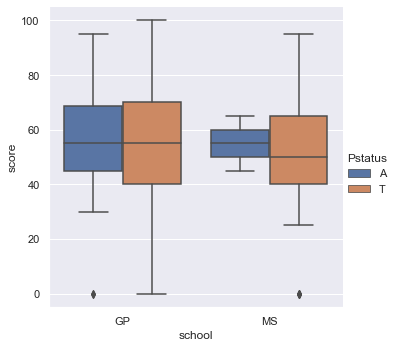

In [23]:
sns.catplot(x='school', y='score', hue='Pstatus', kind='box', data=math_data)

In [24]:
math_data.groupby(['school'])['Pstatus'].value_counts()

school  Pstatus
GP      T          272
        A           34
MS      T           42
        A            2
Name: Pstatus, dtype: int64

###### Вывод по колонке schoolsup
Большинство детей 335 не получают в школе поддержку. Дети с поддержкой имеют балл ниже. Один студент с поддержкой получил 0 баллов, все остальные, получившие ноль баллов поддержки не имели. Если сравнить две школы, то в школе 'MS' не оказывают поддержку.Имеется 9 попусков. Предлагаю заполнить их занчением 'no', если это дети из школы 'MS'. Если дети учатся в другой школе, в общем случае рекомендуется заполнить модой или если реультат экзамена меньше среднего заполнить значением 'yes'. Данные распределны в заданном диапазоне.

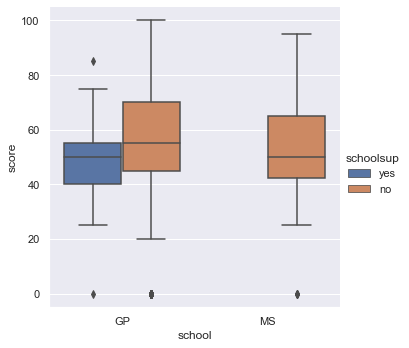

In [27]:
sns.catplot(x='school', y='score', hue='schoolsup', kind='box', data=math_data)

In [28]:
# данные по пропускам в колонке schoolsup
nan_rows = math_data[math_data['schoolsup'].isnull()]
nan_rows

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
27,GP,M,15,U,GT3,T,4.0,2.0,health,services,other,mother,1.0,1.0,0.0,NaN,no,yes,no,yes,-3.0,yes,yes,NaN,2.0,2.0,4.0,1.0,4.0,75.0
35,GP,F,15,U,GT3,T,2.0,3.0,other,other,other,father,NaN,1.0,0.0,NaN,yes,no,yes,yes,-3.0,yes,no,no,3.0,5.0,1.0,5.0,0.0,30.0
79,GP,F,16,U,NaN,T,3.0,4.0,at_home,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,-6.0,yes,yes,no,2.0,4.0,3.0,3.0,12.0,25.0
151,GP,M,16,U,LE3,T,2.0,1.0,at_home,NaN,course,mother,1.0,1.0,1.0,NaN,no,no,yes,yes,-3.0,yes,no,yes,4.0,4.0,4.0,5.0,6.0,70.0
211,GP,M,17,U,LE3,T,4.0,4.0,services,other,home,mother,1.0,2.0,0.0,NaN,yes,yes,no,yes,-6.0,yes,yes,yes,5.0,3.0,5.0,3.0,13.0,65.0
274,GP,F,17,U,GT3,T,2.0,4.0,at_home,health,reputation,mother,2.0,2.0,0.0,NaN,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,3.0,3.0,1.0,2.0,50.0
321,GP,F,17,U,GT3,T,2.0,2.0,other,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,-6.0,yes,no,yes,4.0,2.0,2.0,3.0,12.0,45.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
394,MS,M,19,U,LE3,T,1.0,1.0,other,at_home,NaN,father,1.0,1.0,0.0,NaN,no,no,no,yes,-3.0,yes,yes,no,3.0,2.0,3.0,5.0,5.0,45.0


###### Вывод по колонке famsup
219 детей (более 60%) получат поддержку в семье. Зависимости между поддержкой и результатами не обнаружено. Пропуски в данных составляют 39. При заполнении данных модно учесть, если родители медицинские работники или учителя, то они чаще оказывабт поддержку. Также при повыщении уровня образования до 3-4 возрастает поддержка. Данные принимают значения из заданного диапазона.

In [29]:
math_data.groupby(['Mjob'])['famsup'].value_counts()

Mjob      famsup
at_home   yes       31
          no        25
health    yes       21
          no         6
other     yes       63
          no        56
services  yes       58
          no        30
teacher   yes       35
          no        14
Name: famsup, dtype: int64

In [30]:
math_data.groupby(['Medu'])['famsup'].value_counts()

Medu  famsup
0.0   no         2
1.0   no        31
      yes       24
2.0   yes       53
      no        38
3.0   yes       56
      no        33
4.0   yes       84
      no        32
Name: famsup, dtype: int64

###### Вывод по колонке paid
Больше половины школьников не посещает оплачиваемых занятий по математике, имеется 40 пропусков.  Зависимости между признаками score и paid не прослеживается. Можно отметить только, что чуть меньше низких оценок в категории детей, посещающих дополнительные занятия по математике. Несколько иначе будет выглядеть распределение, если данные сгруппировать по адресу. За городом дополнительные занятия по математике дети посещают почти в два раза меньше, чем те, которые посещают. Распределение "да" - "нет" в городе примерно одинаково. Также среди детей, у которых родители работают учителями или мать имеет образование категории 4 чаще посещают платные занятия по математике. Признак принимает значения в описанном диапазоне.

In [31]:
math_data.groupby(['address'])['paid'].value_counts()

address  paid
R        no       45
         yes      28
U        no      147
         yes     119
Name: paid, dtype: int64

In [32]:
# заменить Medu на Mjob или Fjob
math_data.groupby(['Medu'])['paid'].value_counts()

Medu  paid
0.0   no       2
      yes      1
1.0   no      39
      yes     15
2.0   no      53
      yes     40
3.0   no      54
      yes     34
4.0   yes     65
      no      49
Name: paid, dtype: int64

###### Вывод по колонке activities
Примерно одинаковое количество посещает/ не посещает кружки и секции (дополнительные занятия). Имеется 14 пропусков, предлагается заполнить модой. Данные принимают значения в заданном диапазоне. Среднее значение для обеих категорий учащихся практически одинаковое. У учеников, посещающих дополнительные занятия, немного выше низкие оценки и больше высоких оценок.  

###### Вывод по колонке nursery
Большая часть детей посещала детский сад. Вариант ответа "да" - 300, "нет" - 79 и пропуски в данных - 16. Существенной разницы в итоговой оценке по математике между детьми посещавшими и непосещавшими детский сад нет. Признак принимает значения в заданном диапазоне.

###### Вывод по колонке higher
95% и  5% составляют ответы "да" и "нет" на вопрос хотят ли дети получать высшее образование? Пропуски в данных составляют 19. Разница средних баллов по экзамену у этих двух категорий учащихся составляет 20 и в целом результаты значительно выше у детей, планирующих продолжить обучение.  

###### Вывод по колонке internet
Более 80% детей имеют доступ к интернету, и имеют баллы за экзамен немного выше, чем дети не имеющие доступ к интернету. Есть пропуски, их количество 34. Данные принимают заданные значения "да" и "нет".

###### Вывод по колонке romantic
Распределение детей, имеющих и не имеющих романтические отношения примерно составляет 40% и 60% соответственно. Наличие и отсутствие отношений сказывается на результатах экзамена. Учащиеся, которые имеют романтические отношения в среднем сдают на 7 баллов хуже, а также процент детей, сдавших экзамен ниже среднего, больше. 31 пропуск в данных можно заменить модой, как рекомендуется для категориальных данных. У мальчиков у целом различия в результатах с отношени или без более заменты, что проиллюстрировано на босксплотах ниже. 

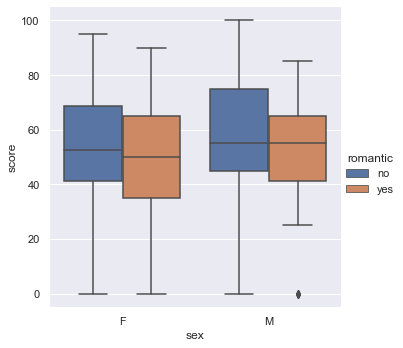

In [33]:
sns.catplot(x='sex', y='score', hue='romantic', kind='box', data=math_data)

## 2.2 Категориальные и номинативные признаки

А теперь приступим к рассмотрению категориальных и номинальных переменных, построим диаграммы и сделаем выводы по этим данным 

Колонка: Medu
Уникальные значения: [ 4.  1.  3.  2. nan  0.]

Распределение значений:      Medu
4.0   131
2.0   102
3.0    97
1.0    59
0.0     3
NaN     3

Статистика колонки:              Medu
count  392.000000
mean     2.750000
std      1.098127
min      0.000000
25%      2.000000
50%      3.000000
75%      4.000000
max      4.000000


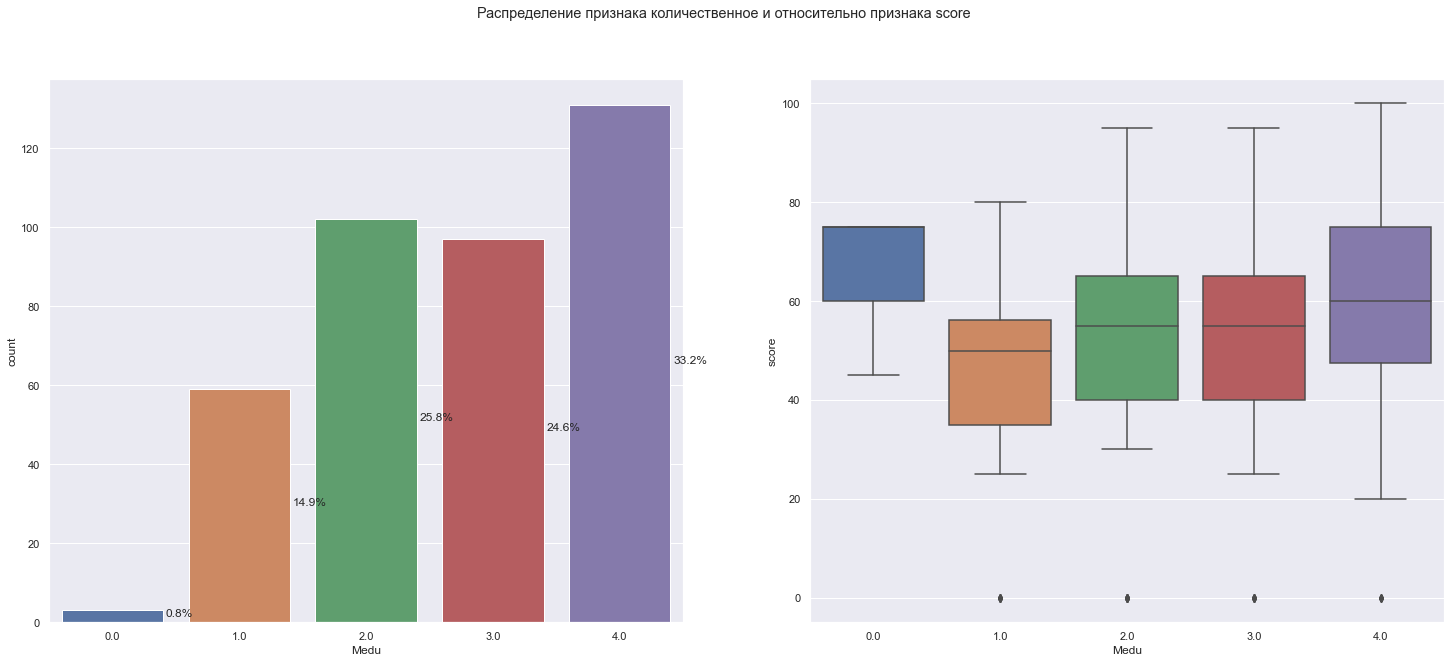



Колонка: Fedu
Уникальные значения: [ 4.  1.  2.  3. 40. nan  0.]

Распределение значений:       Fedu
2.0    106
3.0     96
4.0     88
1.0     78
NaN     24
0.0      2
40.0     1

Статистика колонки:              Fedu
count  371.000000
mean     2.614555
std      2.228732
min      0.000000
25%      2.000000
50%      2.000000
75%      3.000000
max     40.000000


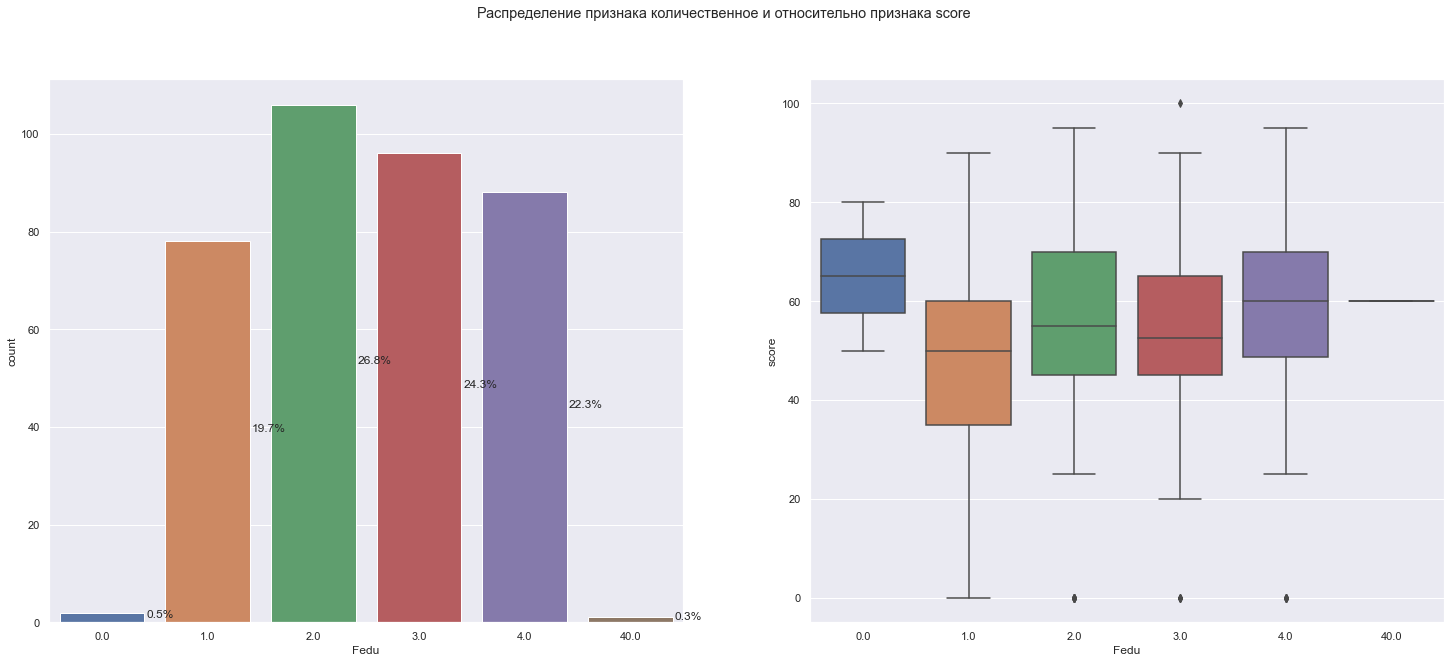



Колонка: Mjob
Уникальные значения: ['at_home' 'health' 'other' 'services' 'teacher' nan]

Распределение значений:           Mjob
other      133
services    98
at_home     58
teacher     55
health      32
NaN         19

Статистика колонки:          Mjob
count     376
unique      5
top     other
freq      133


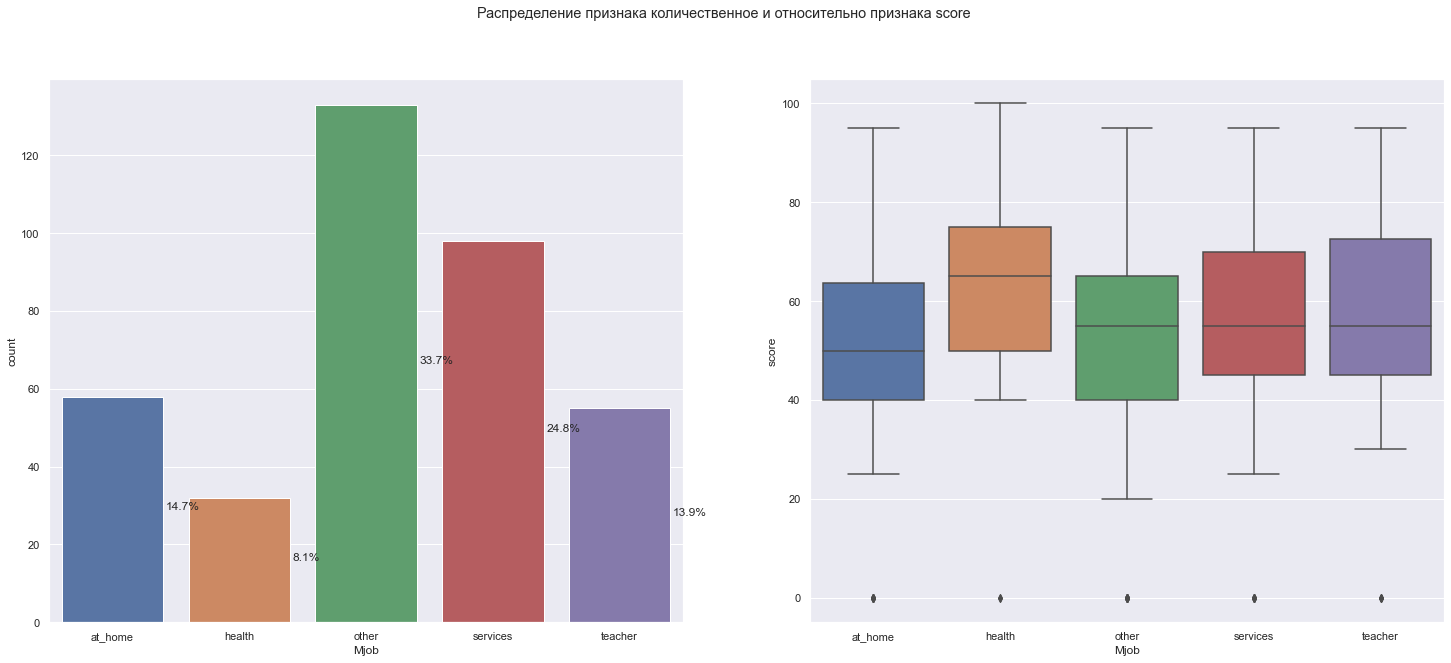



Колонка: Fjob
Уникальные значения: ['teacher' 'other' nan 'health' 'services' 'at_home']

Распределение значений:           Fjob
other      197
services   102
NaN         36
teacher     29
at_home     16
health      15

Статистика колонки:          Fjob
count     359
unique      5
top     other
freq      197


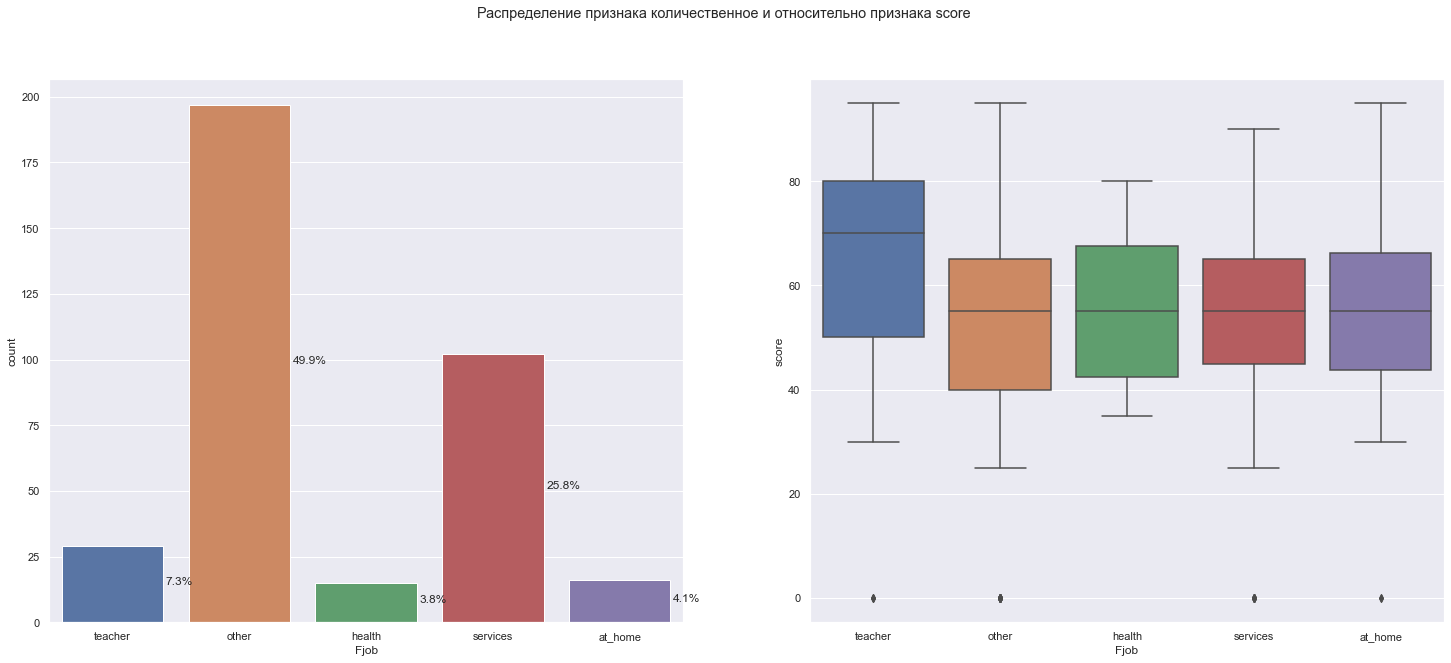



Колонка: reason
Уникальные значения: ['course' 'other' 'home' 'reputation' nan]

Распределение значений:             reason
course         137
home           104
reputation     103
other           34
NaN             17

Статистика колонки:         reason
count      378
unique       4
top     course
freq       137


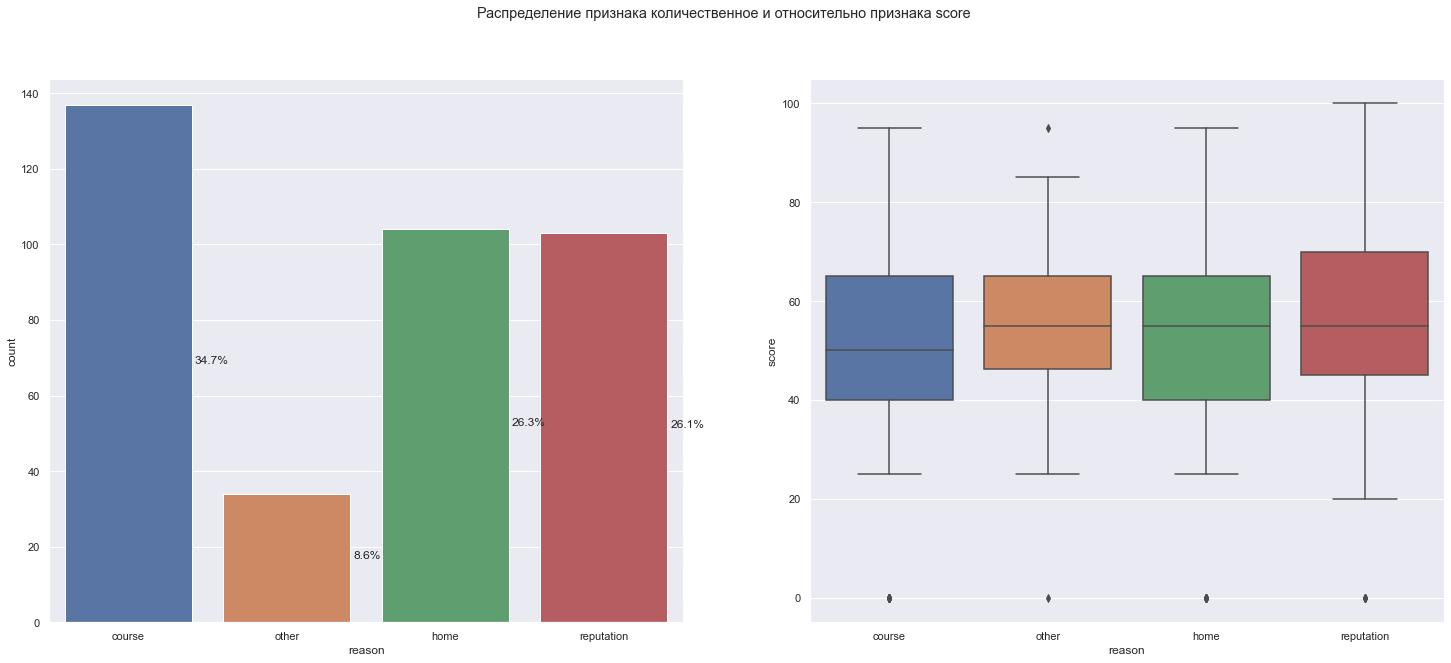



Колонка: guardian
Уникальные значения: ['mother' 'father' 'other' nan]

Распределение значений:         guardian
mother       250
father        86
NaN           31
other         28

Статистика колонки:        guardian
count       364
unique        3
top      mother
freq        250


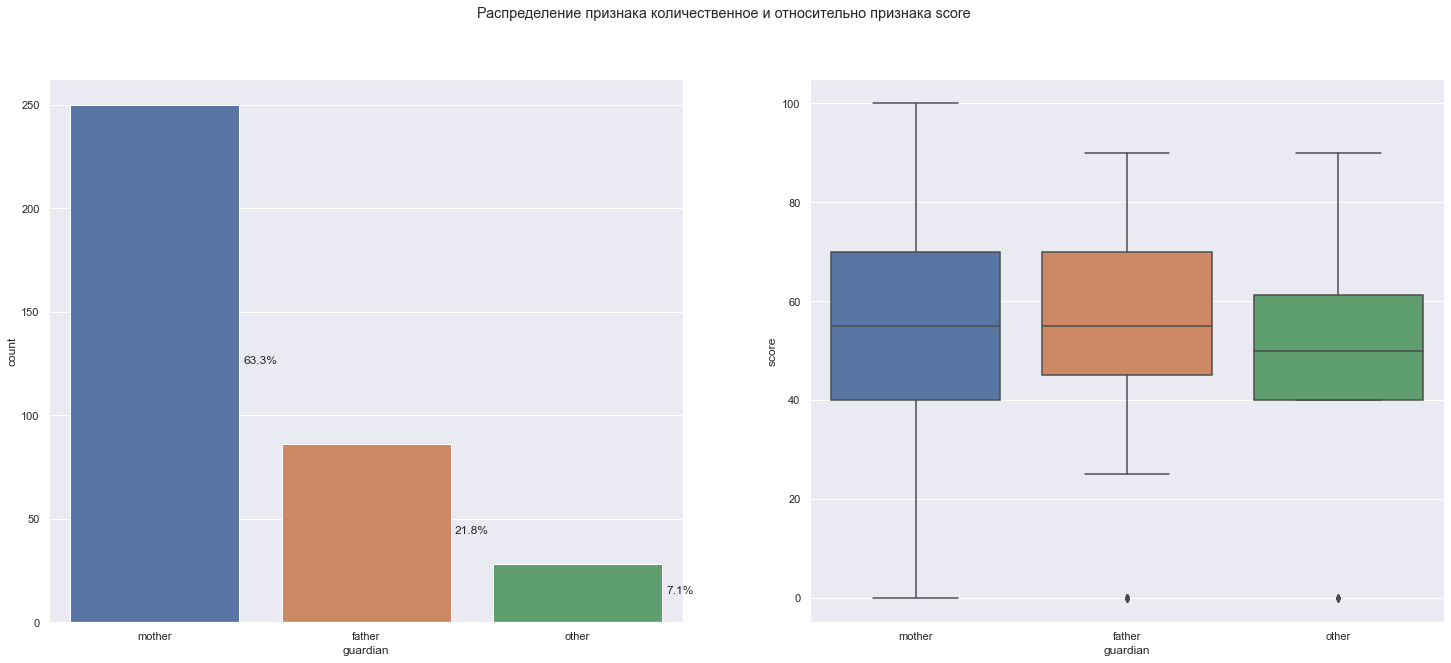



Колонка: traveltime
Уникальные значения: [ 2.  1.  3. nan  4.]

Распределение значений:      traveltime
1.0         242
2.0          96
NaN          28
3.0          22
4.0           7

Статистика колонки:        traveltime
count  367.000000
mean     1.438692
std      0.694181
min      1.000000
25%      1.000000
50%      1.000000
75%      2.000000
max      4.000000


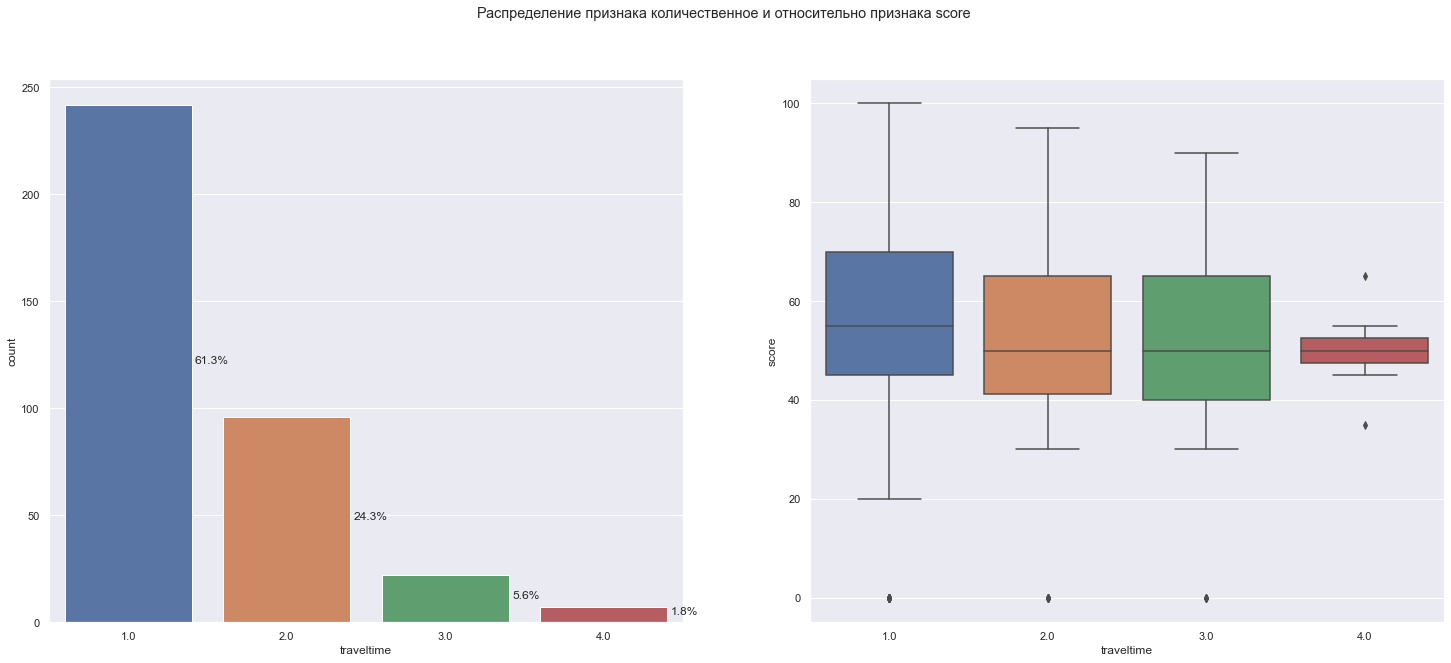



Колонка: studytime
Уникальные значения: [ 2.  3.  1. nan  4.]

Распределение значений:      studytime
2.0        194
1.0        103
3.0         64
4.0         27
NaN          7

Статистика колонки:         studytime
count  388.000000
mean     2.038660
std      0.842078
min      1.000000
25%      1.000000
50%      2.000000
75%      2.000000
max      4.000000


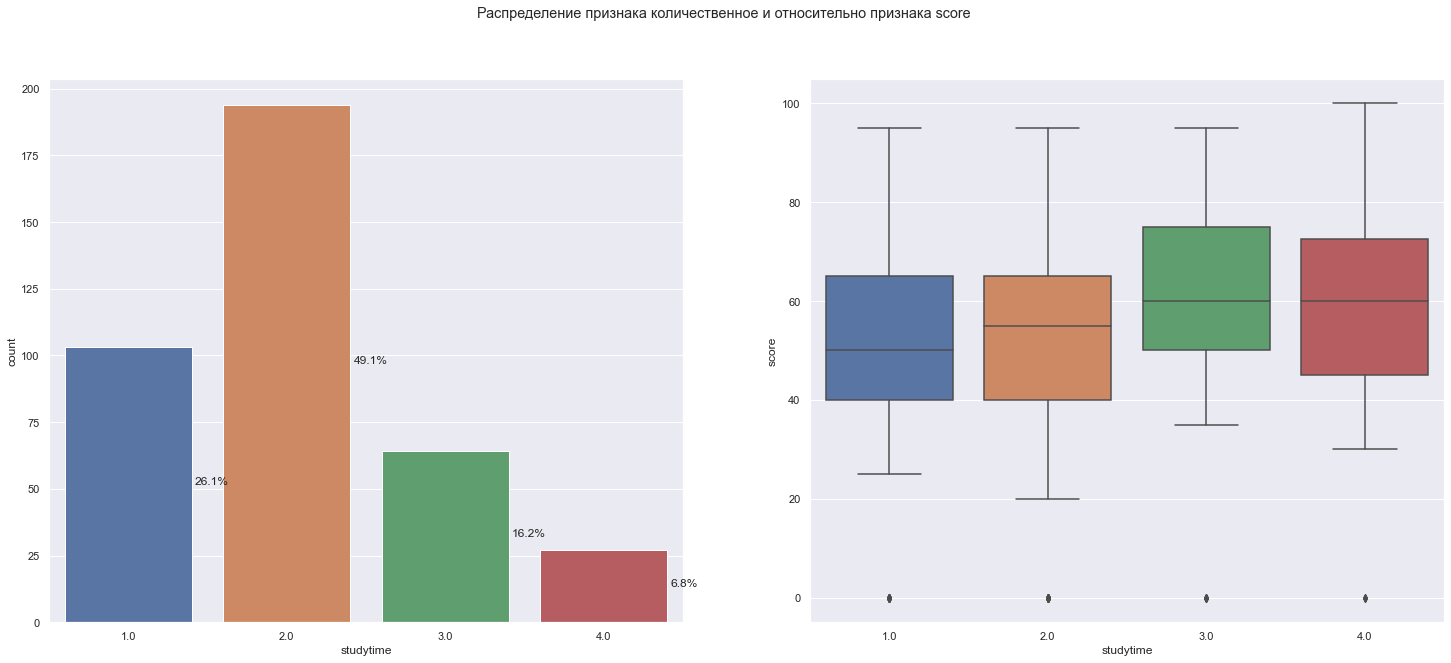



Колонка: failures
Уникальные значения: [ 0.  3. nan  2.  1.]

Распределение значений:      failures
0.0       293
1.0        49
NaN        22
2.0        16
3.0        15

Статистика колонки:          failures
count  373.000000
mean     0.337802
std      0.743135
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      3.000000


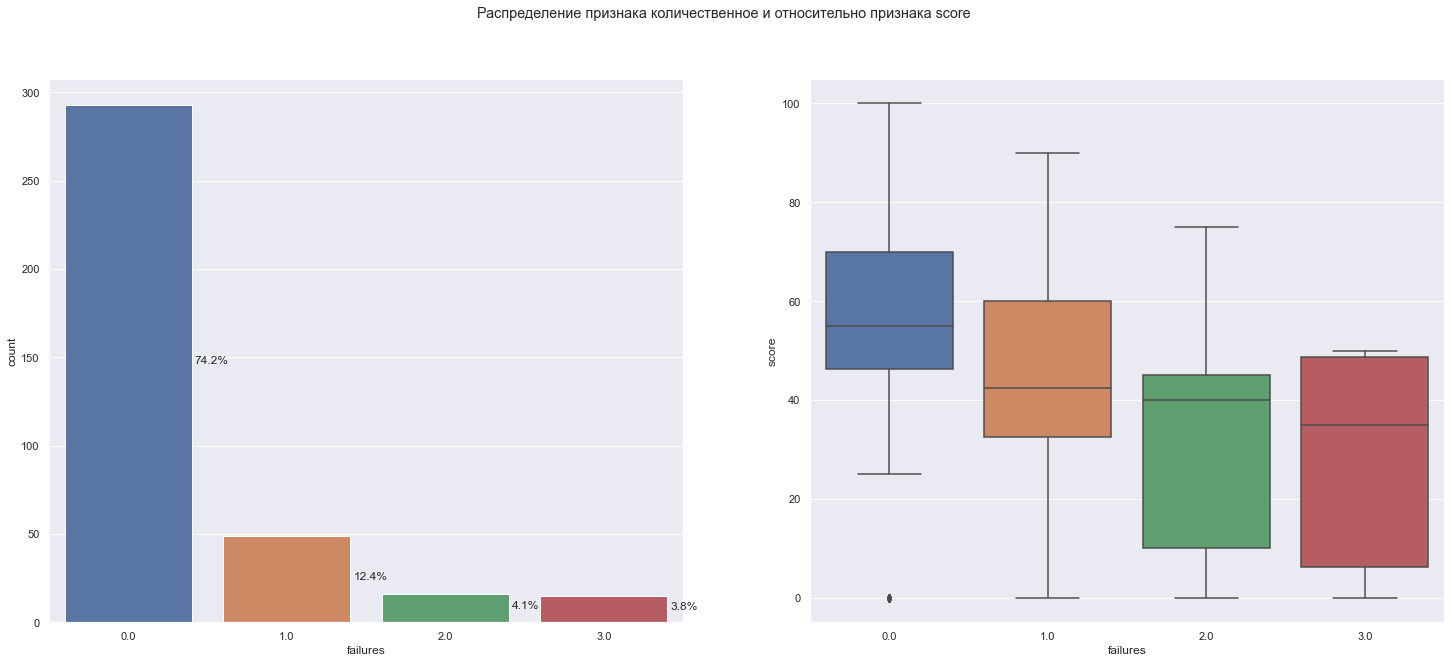



Колонка: famrel
Уникальные значения: [ 4.  5.  3. nan -1.  2.  1.]

Распределение значений:       famrel
 4.0     182
 5.0      99
 3.0      62
 NaN      27
 2.0      17
 1.0       7
-1.0       1

Статистика колонки:            famrel
count  368.000000
mean     3.937500
std      0.927277
min     -1.000000
25%      4.000000
50%      4.000000
75%      5.000000
max      5.000000


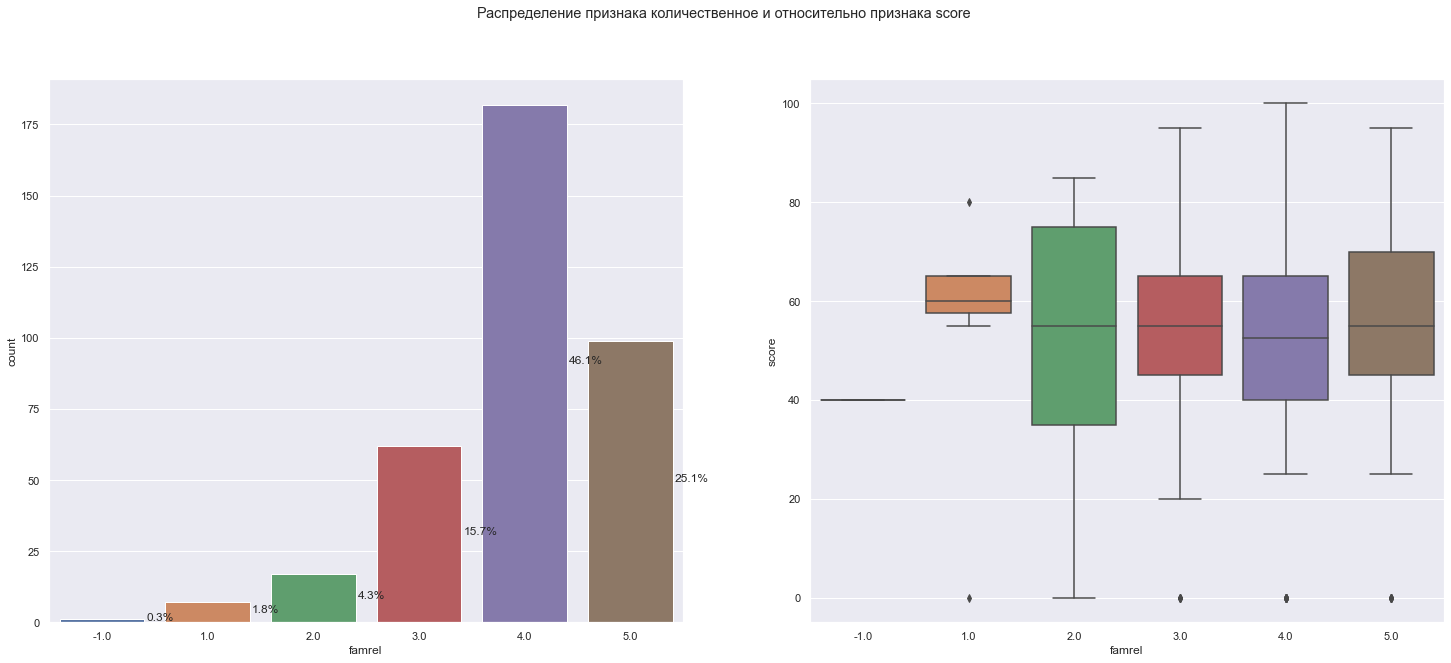



Колонка: freetime
Уникальные значения: [ 3.  2.  4.  1.  5. nan]

Распределение значений:      freetime
3.0       153
4.0       112
2.0        63
5.0        38
1.0        18
NaN        11

Статистика колонки:          freetime
count  384.000000
mean     3.231771
std      0.993940
min      1.000000
25%      3.000000
50%      3.000000
75%      4.000000
max      5.000000


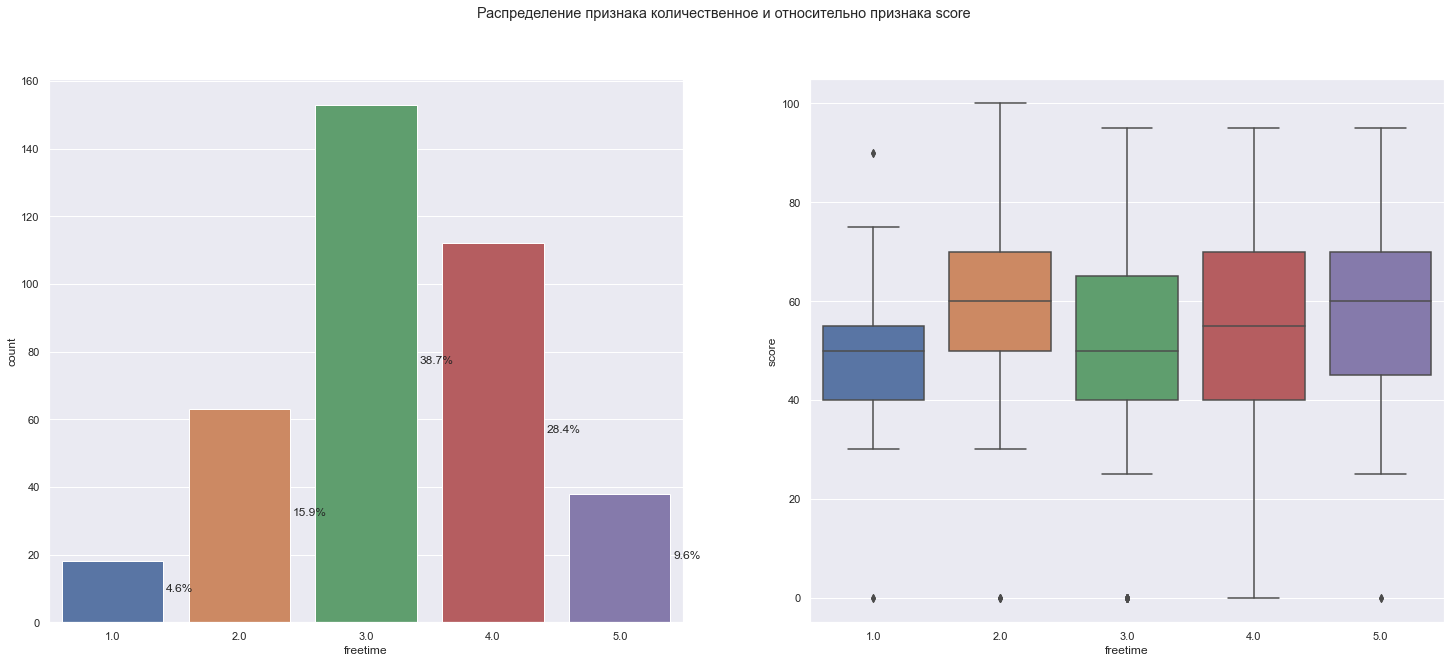



Колонка: goout
Уникальные значения: [ 4.  3.  2.  1.  5. nan]

Распределение значений:      goout
3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
NaN      8

Статистика колонки:             goout
count  387.000000
mean     3.105943
std      1.115896
min      1.000000
25%      2.000000
50%      3.000000
75%      4.000000
max      5.000000


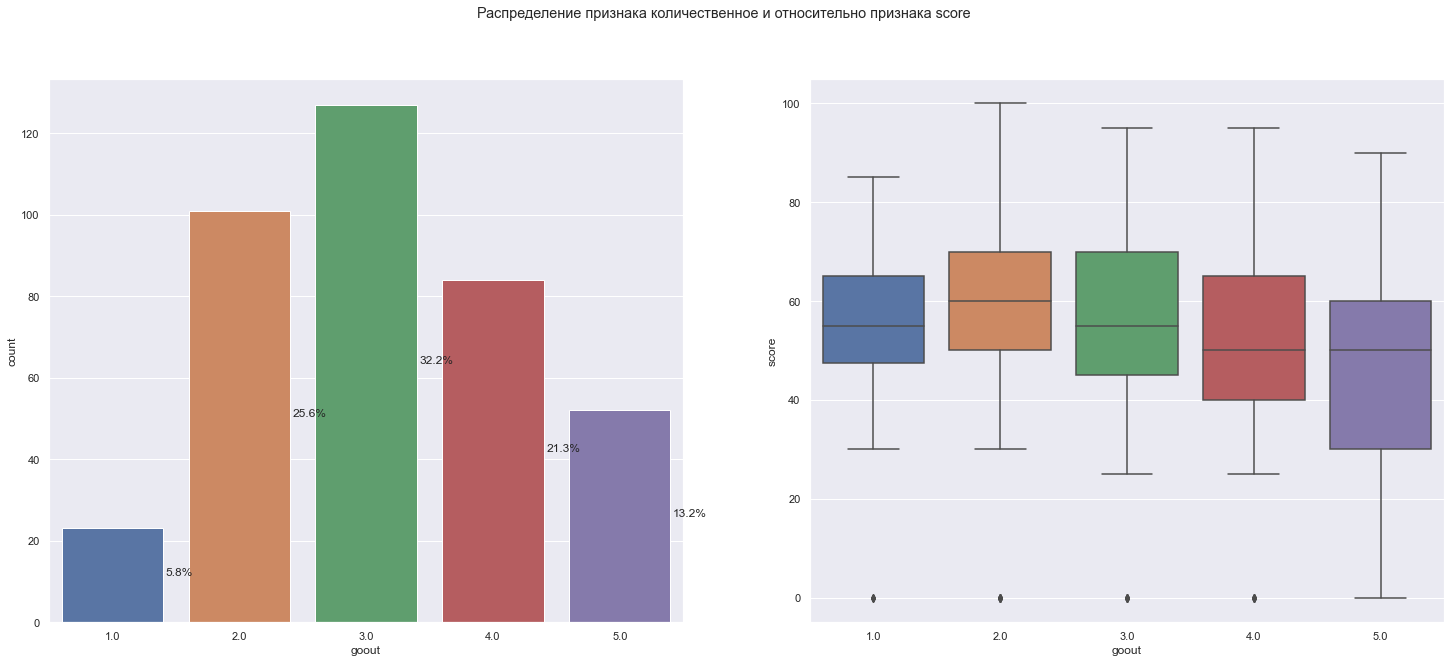



Колонка: health
Уникальные значения: [ 3.  5.  1.  2.  4. nan]

Распределение значений:      health
5.0     138
3.0      89
4.0      63
1.0      47
2.0      43
NaN      15

Статистика колонки:            health
count  380.000000
mean     3.531579
std      1.396019
min      1.000000
25%      3.000000
50%      4.000000
75%      5.000000
max      5.000000


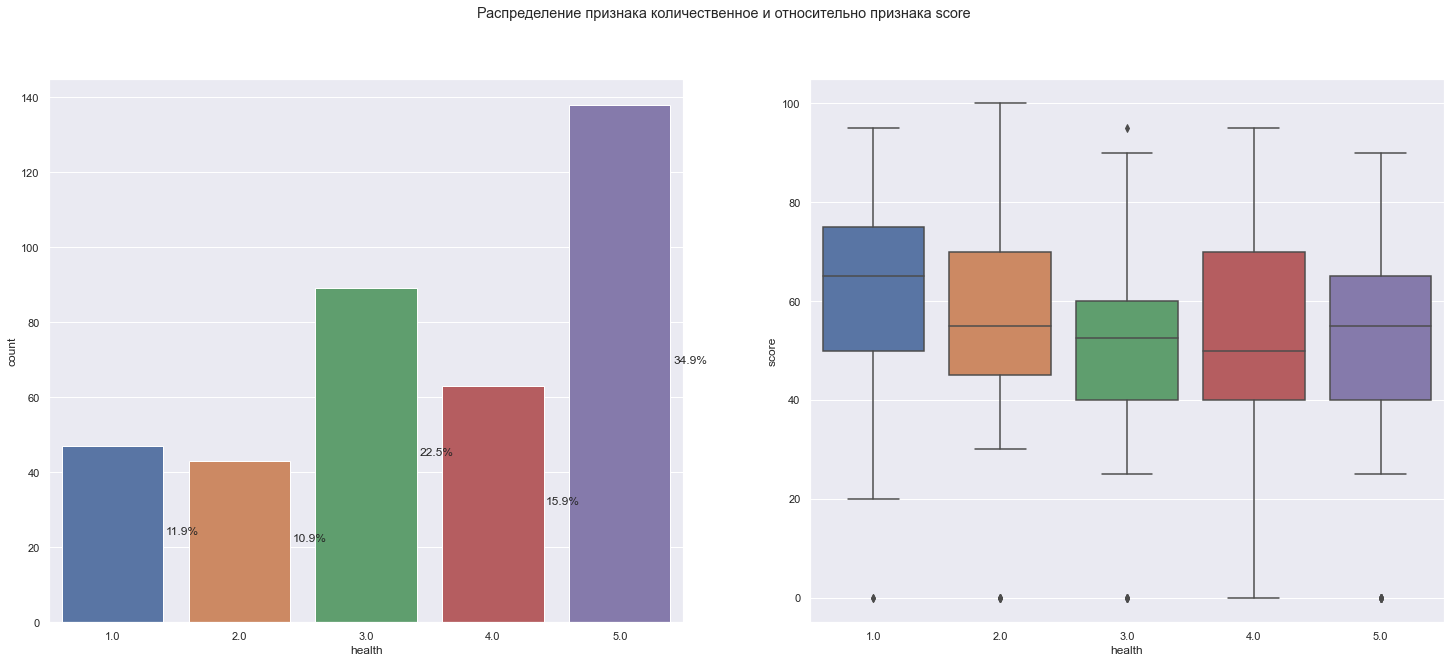

In [34]:
for columns in categorical:               # задаем цикл для категориальных переменных
    # вызываем функцию для обработки категориальных переменных
    categorical_col_analysis(columns)
    print('')
    print('')

###### Общие выводы по  колонкам с категориальными  и номинативными переменными
* Балл за экзамен тем выше, чем выше уровень образования матери. Исключения составляют дети, у которых матери не имеют образования (значение - 0), но количественно - это только 3 учащихся. Большинство составляют матери с высшим образованием 33,2%.
* В образовании отцов наиболее представлена группа, где у отцов образование уровня 2 - 5-9 классы. Наблюдается похожая корреляция оценок, но не так явно как в случае с матерями. Также есть 2 студента у которых отцы не имеют образования и которые показали очень хороший результат.
* В колонках работа матери, работа отца самыми популярными являются другое и серсис (работа в администрации, полиции и т.п.). Больше матерей работает учителями, медицинскими работниками  и сидят дома, по сравнению с отцами. Распредения в процентном соотнощении представлено на бар плоте. Не наблюдается влияния работы отцов на результаты учащихся. По отношению к работу матерей лучших результатов достигли дети врачей и учителей.
* Самый популярный ответ для выбора школ - это предлагаемые курсы, и примерно одинаковое количество у категорий - близость к дому и репутация школы. 
* В большинстве семей опекуном является мать. Большой разницы в результах в зависимости от того, кто в семье опекун не наблюдается. Можно лишь отметить, если опекун - другое, то результаты в целом чуть ниже. 
* Основная часть детей (61%) тратит на дорогу до школы менее 15 минут, их результаты в целом чуть выше и бокслот смещен вверх
* Примерно 50% детей помимо школы занимаются от 2 до 5 часов и примерно 25% тратят на учебу до 2 часов. Однако лучшие результаты показали дети, которые занимаются от 5 до 10 часов. Клонку studytime granular предлагаю удалить из набора данных, так как она повторяет колонку studytime
* Большинство студентов не имеют внешкольных ошибок и результат тем выше, чем ощибок меньше.
* Наиболее часто встречающимися ответами на вопрос о семейных отношениях являются хорошие и отличные.
* Большинство студентов оценивает количество свободного времени в диапазоне среднее и много( шкала: от 1 - очень мало до 5 - очень мого)
* Также большинство детей оценивает как среднее количество времени проведенного с друзьями, в целом чем больше времени учащиеся проводят в друзьями, тем ниже их результат на экзамене.
* Уровень здоровья детей мало связан с результатами экзамена и большинством детей оценивается как среднее и отличное. Дети с низким уровнем здоровья показали результат чуть лучше.


Значения переменнных, которые не вошли в описываемый диапазон: образование отца(Fedu) - одно значение 40, отношения в семье(famrel) - одно значение - 1. Эти значения больше похожи на опечатки, предлагаю аменить их на 4 и 1 соответственно.

In [35]:
math_data.loc[math_data.Fedu == 40, 'Fedu'] = 4  # заменяем значение 40 на 4

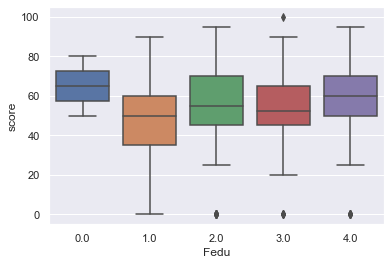

In [36]:
sns.boxplot(x='Fedu', y='score', data=math_data)  # проверяем на боксплоте

In [37]:
math_data.loc[math_data.famrel == -1, 'famrel'] = 1

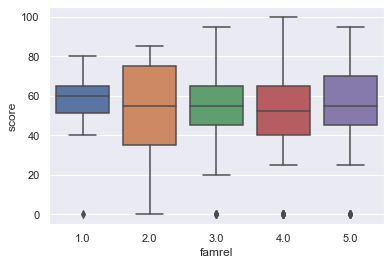

In [38]:
sns.boxplot(x='famrel', y='score', data=math_data)

Удалим колонку 'studytime, granular', потому что она полностью дублирует колонку 'studytime'

In [108]:
math_data.drop('studytime, granular', axis=1, inplace=True)

## 2.3  Числовые признаки

Итак, нам осталось посмотреть на распределение числовых признаков, их только три - это 'age' (возраст), 'absences' (пропуски) и 'score' (баллы по экзамену). Последний это наша целевая переменная, которую нужно будет предсказывать. Посмотрим на распределение этих переменных и построим для них гистограммы, для этого вызовем функцию обработки числовых переменных.

In [40]:
print(numeric_col)

['age', 'absences', 'score']


Колонка: age
Уникальные значения: [18 17 15 16 19 22 20 21]

Распределение значений:     age
16  104
17   98
18   82
15   82
19   24
20    3
22    1
21    1

Статистика колонки:               age
count  395.000000
mean    16.696203
std      1.276043
min     15.000000
25%     16.000000
50%     17.000000
75%     18.000000
max     22.000000


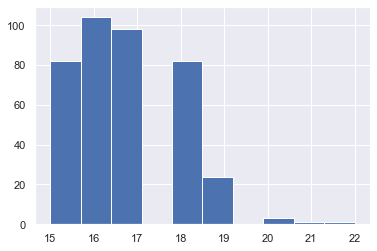

Колонка: absences
Уникальные значения: [  6.   4.  10.   2.   0.  16.  nan  14.   7.   8.  25.  12.  54.  18.
  26.  20.  56.  24.  28.   5.  13.  15.  22.   3. 385.  21.   1.  75.
  30.  19.   9.  11.  38.  40.  23.  17. 212.]

Распределение значений:        absences
0.0         111
2.0          60
4.0          53
6.0          31
8.0          21
10.0         17
12.0         12
NaN          12
14.0         12
3.0           8
16.0          7
7.0           6
5.0           5
18.0          5
20.0          4
1.0           3
22.0          3
9.0           3
13.0          2
15.0          2
11.0          2
25.0          1
54.0          1
385.0         1
26.0          1
56.0          1
24.0          1
212.0         1
21.0          1
75.0          1
30.0          1
19.0          1
38.0          1
40.0          1
23.0          1
17.0          1
28.0          1

Статистика колонки:          absences
count  383.000000
mean     7.279373
std     23.465197
min      0.000000
25%      0.000000
50%      4

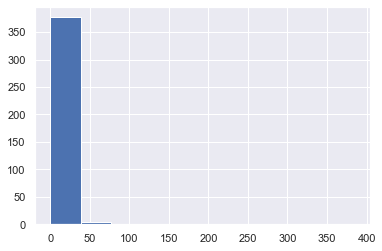

Колонка: score
Уникальные значения: [ 30.  50.  75.  55.  95.  45.  60.  70.  80.  25.  40.  85.  90.  65.
 100.  35.   0.  nan  20.]

Распределение значений:        score
50.0      54
55.0      46
0.0       37
75.0      33
65.0      31
40.0      31
60.0      31
45.0      27
70.0      27
80.0      16
30.0      15
90.0      12
35.0       9
25.0       7
NaN        6
85.0       6
95.0       5
100.0      1
20.0       1

Статистика колонки:             score
count  389.000000
mean    52.262211
std     22.919022
min      0.000000
25%     40.000000
50%     55.000000
75%     70.000000
max    100.000000


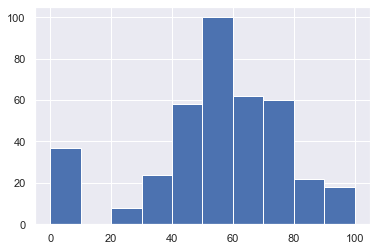

In [41]:
for columns in numeric_col:              # задаем цикл для бинарных переменных
    # вызываем функцию для обработки числовых признаков
    numerical_col_analysis(columns)
    # print(columns)

###### Вывод по колонке age
Средний возраст детей 17 лет. Основная масса детей в возрасте от 15 до 18 лет. Небольшой процент учащихся в возрасте от 19-22 лет. Пропусков в данных нет. Значения принимаемые переменной 'age' в описываемом даипазоне от 15 до 22 лет.

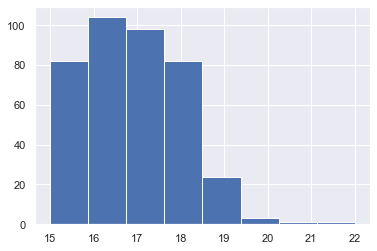

In [42]:
math_data['age'].hist(bins=8)

###### Вывод по колонке absences
В целом очень мало пропусков занятий среднее значение - 4. Диапазон данных в описании к набору данных не задан. В связи с тем, что есть экстремальные значения 212 и 385, построенная гистограмма не является информативной, почти все данные попали в одну колонку. Проверим не связаны ли пропуски занятий с состоянием здоровья. Мы также можем удалить строки с этими данными и посторить гистограмму еще раз. Пропусков в данных - 12, предлагаю заменить их на медиану по этому признаку.

In [43]:
math_data.loc[(math_data['absences'] == 212) | (math_data['absences'] == 385)]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0


Как мы видим пропуски не связаны с состоянием здоровья. Одному из студентов 20 лет и его количество пропусков 212, возможно от него не требовалось посещение занятий, а нужно было только пересдать экзамен. Другой студент при количестве пропусков 385 получил очень высокий балл 85. В этом случае сложно предположить причину пропусков, возможно это ошибка в данных. Удалим эти строки. 

In [63]:
index_names = math_data[(math_data['absences'] == 212)
                        | (math_data['absences'] == 385)].index
math_data.drop(index_names, inplace=True)

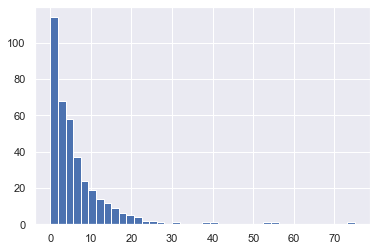

In [45]:
math_data['absences'].hist(bins=40)

###### Вывод по колонке score
Переменная принимает значения от 0 до 100. Среднее значение  55, стандартное отклонение - 23. От 25% и до 75% - значения в диапазоне от 40 до 70 баллов. Есть пропущенные значения - 6.

Посмотрим распределение таргетированного признака  score на графике распределения

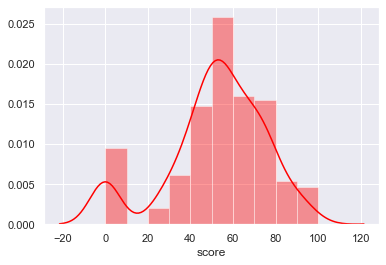

In [46]:
sns.distplot(math_data.score, color='red', bins=10)

  Из-за нулевых значений получилось бимодальное  близкое к симметриному распределение, у которого  хвост с правой стороны, наиболее часто встречаются значения от 40 до 80, пропущены значения от 10-20 баллов. В целом распределение по форме похоже на нормальное. 

# 3. Корреляционный анализ

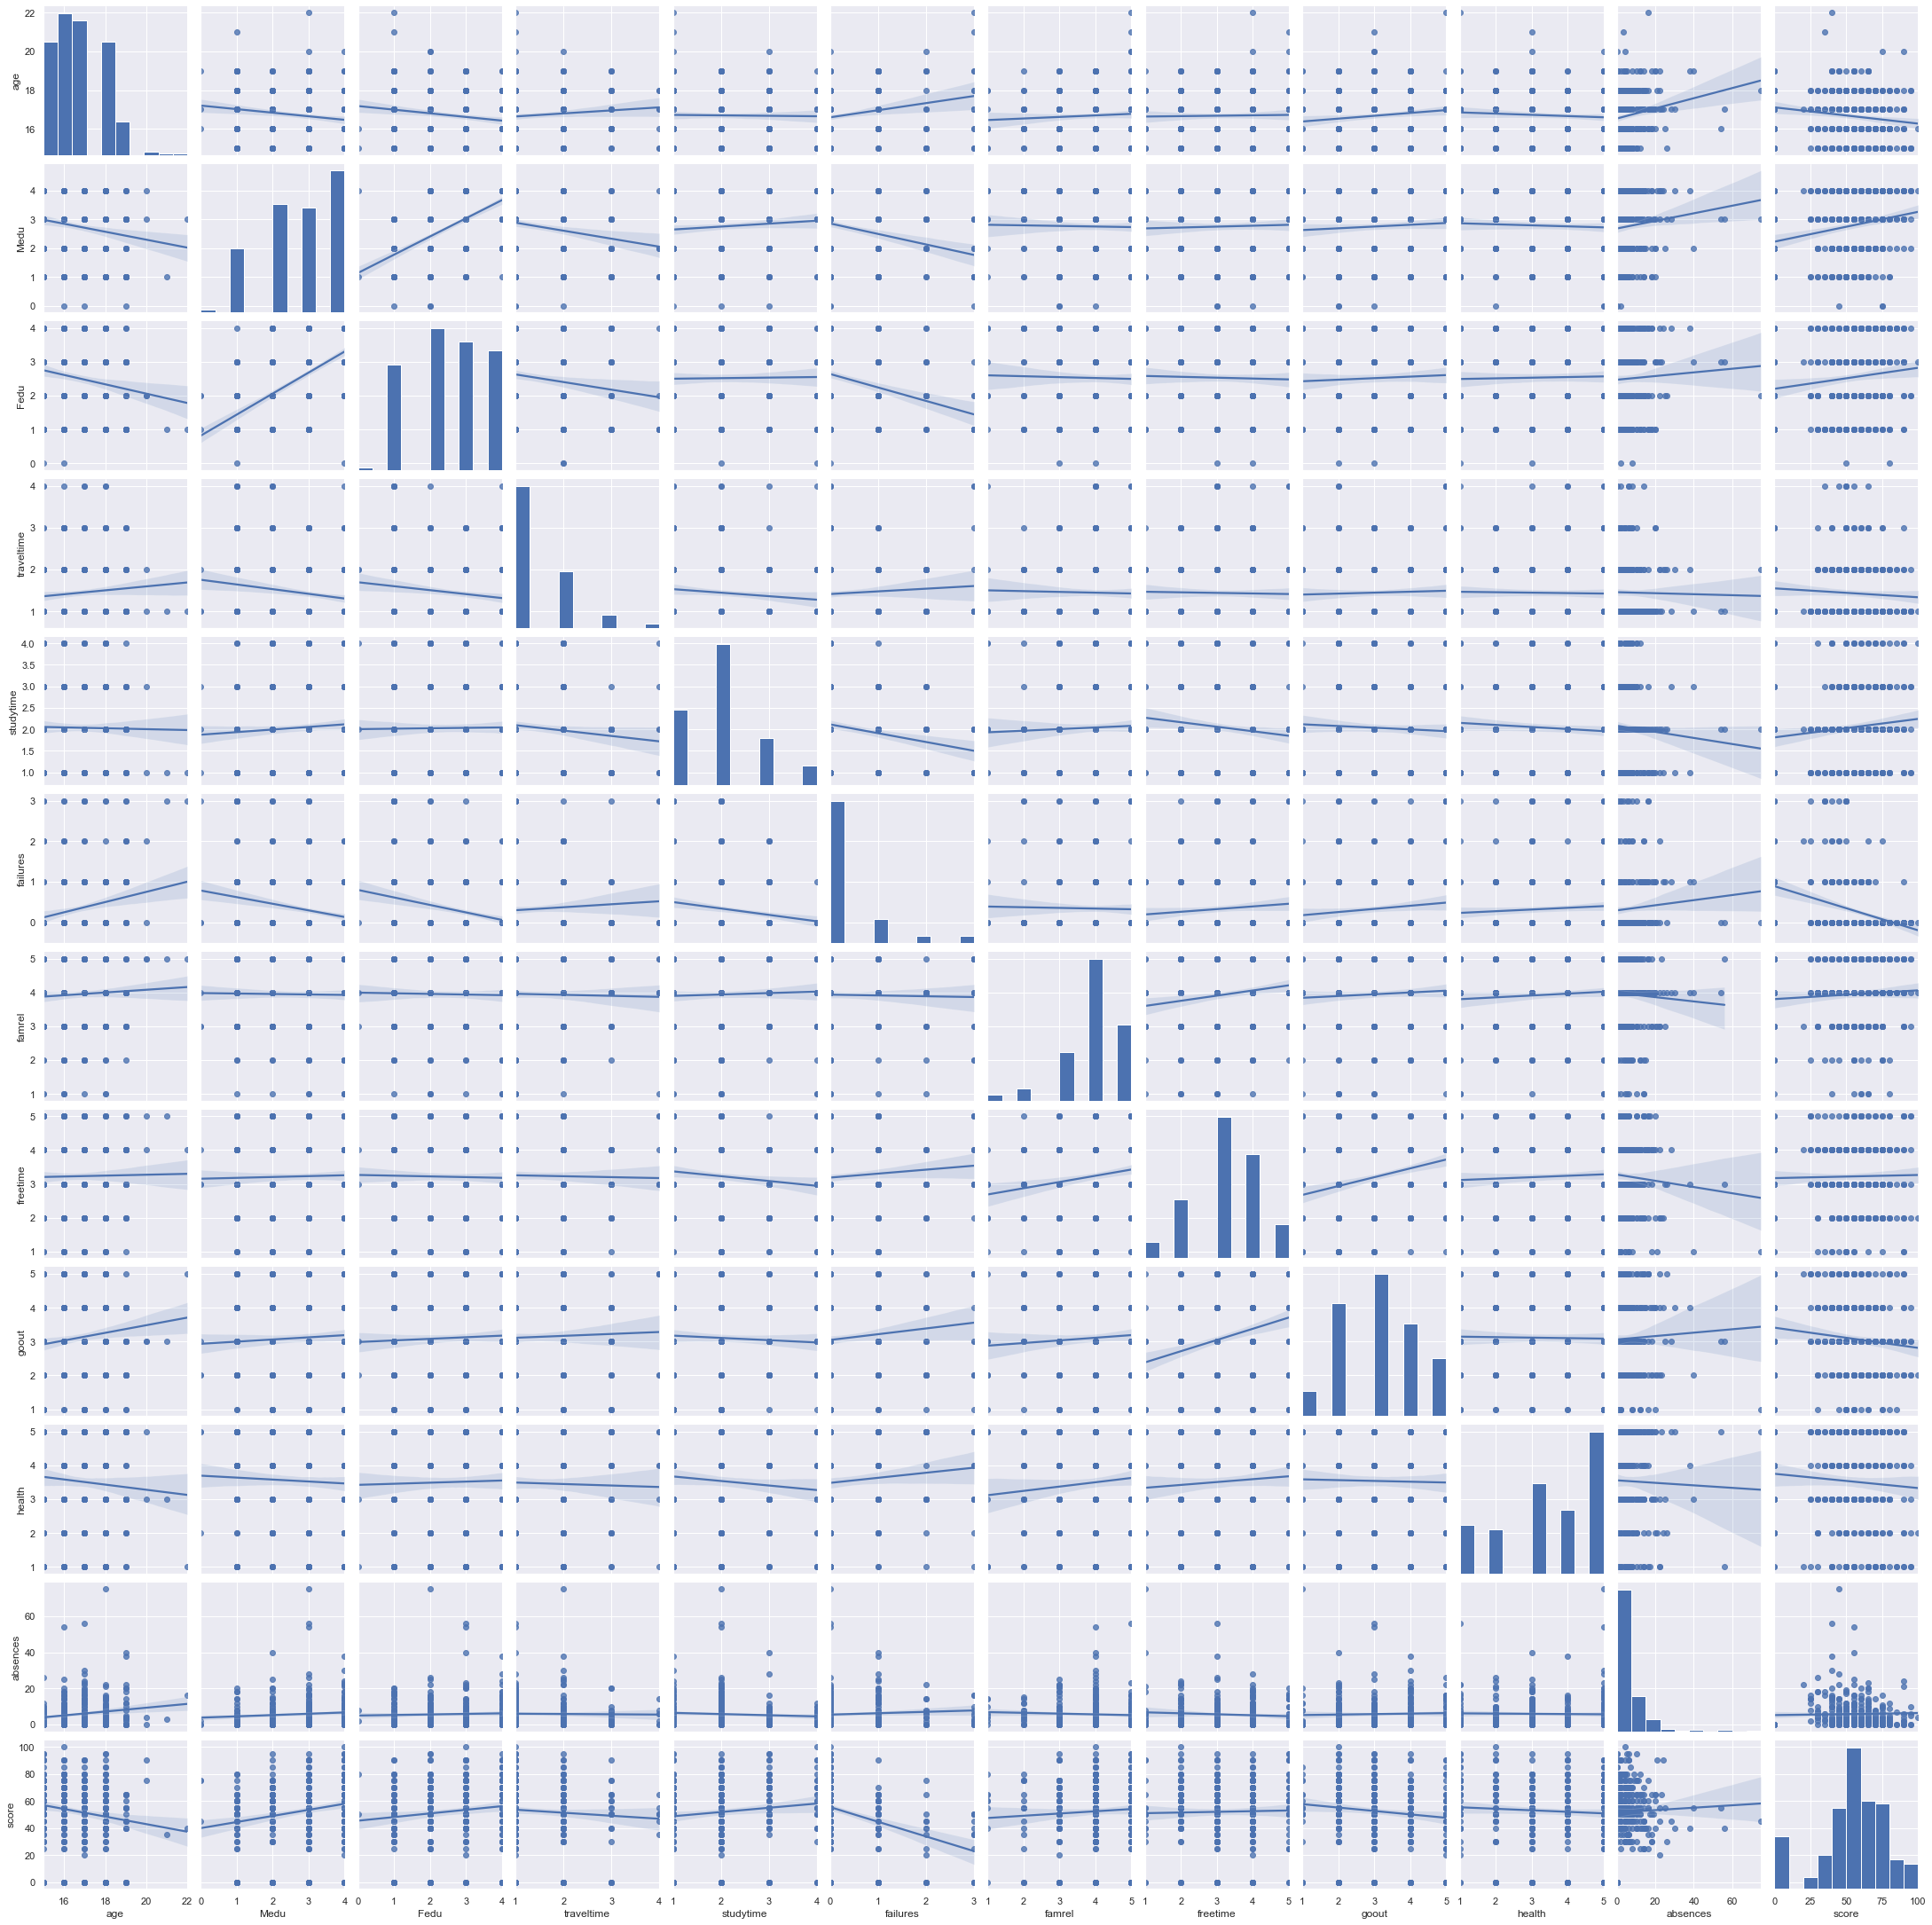

In [47]:
sns.pairplot(data=math_data, kind='reg')

In [48]:
math_data.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.159746,-0.161316,0.085915,-0.015453,0.215351,0.057007,0.016786,0.128993,-0.069429,0.166773,-0.153488
Medu,-0.159746,1.000000,0.626567,-0.176380,0.078509,-0.244267,-0.016460,0.028320,0.062615,-0.045223,0.097295,0.216238
Fedu,-0.161316,0.626567,1.000000,-0.145703,0.012900,-0.271509,-0.022049,-0.023350,0.046331,0.024808,0.040514,0.129242
traveltime,0.085915,-0.176380,-0.145703,1.000000,-0.102496,0.068639,-0.023664,-0.019325,0.035855,-0.021494,-0.014040,-0.068914
studytime,-0.015453,0.078509,0.012900,-0.102496,1.000000,-0.180014,0.039753,-0.122321,-0.051685,-0.080049,-0.067734,0.116202
failures,0.215351,-0.244267,-0.271509,0.068639,-0.180014,1.000000,-0.019835,0.088120,0.115095,0.079300,0.069703,-0.344276
famrel,0.057007,-0.016460,-0.022049,-0.023664,0.039753,-0.019835,1.000000,0.167730,0.064116,0.083675,-0.051402,0.065547
freetime,0.016786,0.028320,-0.023350,-0.019325,-0.122321,0.088120,0.167730,1.000000,0.294446,0.059978,-0.070416,0.021493
goout,0.128993,0.062615,0.046331,0.035855,-0.051685,0.115095,0.064116,0.294446,1.000000,-0.018411,0.036836,-0.122992
health,-0.069429,-0.045223,0.024808,-0.021494,-0.080049,0.079300,0.083675,0.059978,-0.018411,1.000000,-0.021752,-0.068951


Посмотрим корреляцию между числовыми признаками и колонкой score, и сделаем их визуализацию. Для этого построим матрицу корреляции и удалим последний столбец, так как он будет полностью скоррелирован. Также отбросим все слабо скоррелированные признаки (значение меньше 0,12) 

In [49]:
math_datanum_corr = math_data.corr()['score'][:-1]
top_corr = math_datanum_corr[abs(
    math_datanum_corr) > 0.12].sort_values(ascending=False)
print(top_corr)

Medu        0.216238
Fedu        0.129242
goout      -0.122992
age        -0.153488
failures   -0.344276
Name: score, dtype: float64


Мы получили 5 скоррелированных признаков: образование матери и отца, и отрицительную корреляцию по признакам время с друзьями, возраст, предыдущие неудачи.

Построим тепловую карту корреляции по числовым данным>

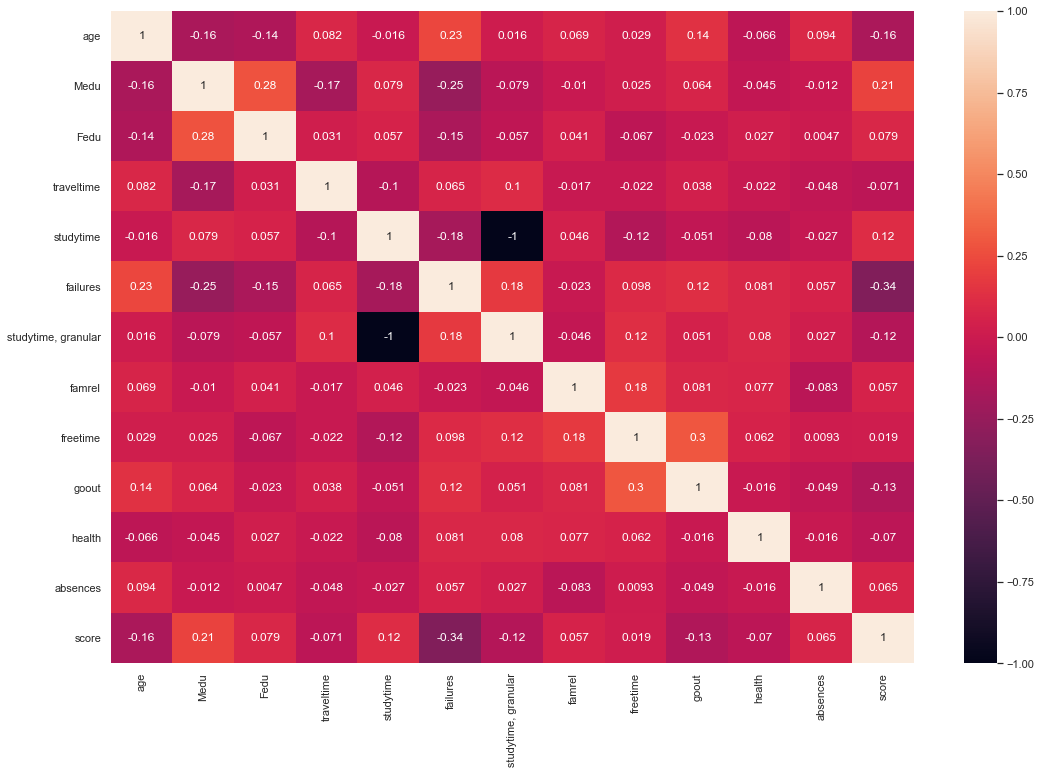

In [60]:
plt.figure(figsize=(18, 12))
sns.heatmap(math_data.corr(), annot=True)

В связи с тем, что в числовые данные также попали категориальные признаки, а для них неободимо проверять корреляцию по методу Спирмана, построим для них матрицу корреляции и на ее основе тепловую диаграмму.

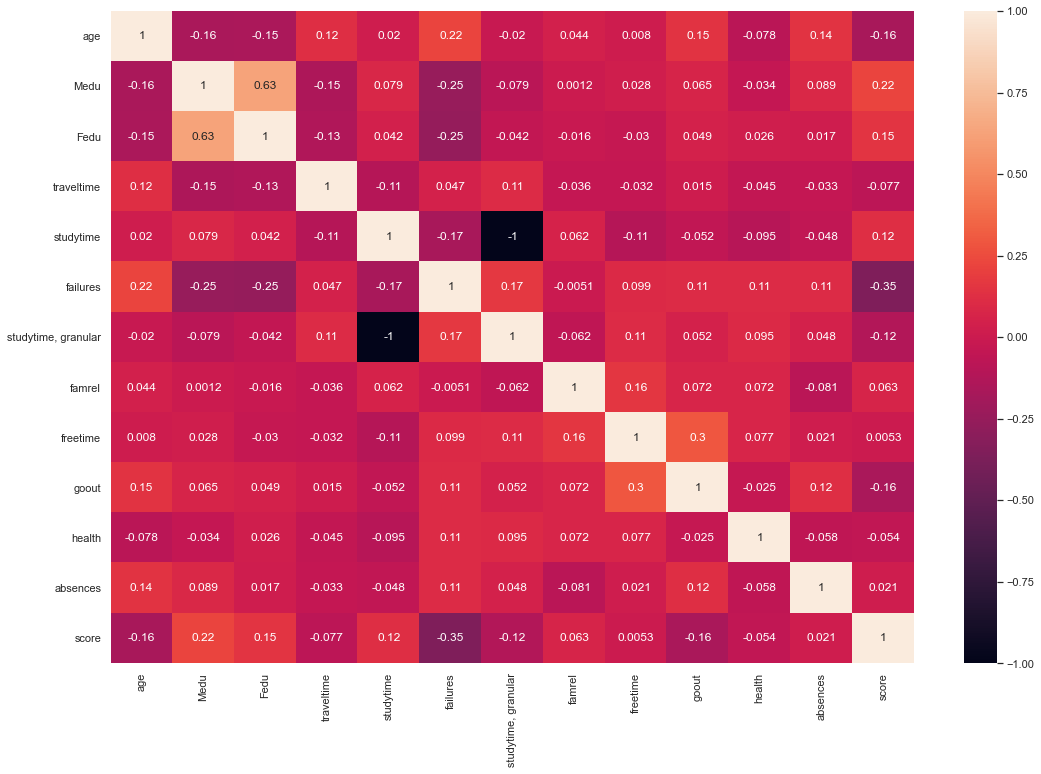

In [61]:
plt.figure(figsize=(18, 12))
sns.heatmap(math_data.corr(method='spearman'), annot=True)

In [62]:
math_datanum_corr_Sp = math_data.corr(method='spearman')['score'][:-1]
top_corr = math_datanum_corr_Sp[abs(
    math_datanum_corr_Sp) > 0.12].sort_values(ascending=False)
print(top_corr)

Medu                   0.220241
Fedu                   0.150172
studytime              0.122527
studytime, granular   -0.122527
goout                 -0.161342
age                   -0.164656
failures              -0.353065
Name: score, dtype: float64


В результате мы получили также, что колонка studytime тоже коррелирует с результатами экзамена. Остальные колонки уже были отобраны при построении корреляции Пирсона, которую рекомендуется применять для числовых признаков. Также следует отметить, что оказались скоррелированы между собой образования матери и отца(0,63) значит можно оставить только один из них, свободное время после школы и время проведенное с друзьями, возраст и количество неудач. 

Применим методы статистики (тест Стьюдента) и оценим  статистическую разницу для номинативных признаков. Для этого из предобработки вызовем функцию get_stat_dif()

In [65]:
for col in categorical:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки Mjob


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


После запуска функции найдены статистически значимые различия только по колонке - работа матери.

# 4. Обработка выбросов и заполнение пропусков 

Проверим, есть ли у нас выбросы в колонке пропуск занятий с помощью интерквартильного размаха. Возьмем за здравый смысл значение 40 (предположим 5 занятий в день, тогда получается 8 дней, что в принципе вполнен допустимо). 

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


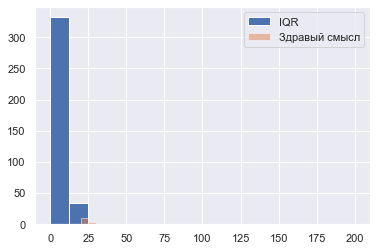

In [94]:
IQR = math_data['absences'].quantile(
    0.75) - math_data['absences'].quantile(0.25)
perc25 = math_data['absences'].quantile(0.25)
perc75 = math_data['absences'].quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
math_data['absences'].loc[math_data['absences'].between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=16, range=(0, 200), label='IQR')
math_data['absences'].loc[math_data['absences'] <= 40].hist(
    alpha=0.5, bins=16, range=(20, 100), label='Здравый смысл')
plt.legend()

После удаления двух экстремальных значений, остальные данные находятся в пределах "здравого смысла".

Для получения выбросов можно воспользоваться функцией find_outliers из предобработки.

In [102]:
find_outliers('age')

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].
За пределами границ значение: 22    1
Name: age, dtype: int64


Так, мы видим для клоноки возраст есть один выброс со значением 22, но мы его не будем удалять, так как он находится в пределах допустимых значений.

Заполним пропуски в данных для числовых - медианой, а для нечисловых данных - модой. 

In [103]:
for col in categorical:
    math_data[col].fillna(math_data[col].mode()[0], inplace=True)

In [105]:
for col in binary:
    math_data[col].fillna(math_data[col].mode()[0], inplace=True)

In [106]:
math_data['absences'].fillna(math_data['absences'].median(), inplace=True)

In [109]:
math_data.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
health        0
absences      0
score         6
dtype: int64

In [110]:
math_datanum_corr_Sp = math_data.corr(method='spearman')['score'][:-1]
top_corr = math_datanum_corr_Sp[abs(
    math_datanum_corr_Sp) > 0.12].sort_values(ascending=False)
print(top_corr)

Medu         0.207903
Fedu         0.143640
studytime    0.122243
goout       -0.159435
age         -0.164656
failures    -0.345938
Name: score, dtype: float64


После заполнения пропусков, корреляция не изменилась

# 5. Общие выводы

###### Основные выводы:
В рассматриваемом наборе данных представлено 395 наблюдений и для каждого из них определено 30 признаков. Это сведения об учащихс>
* В наборе данных имеются незначительные пропуски менее 12%. Больше всего пропусков в колонках Pstatus, paid, famsup, Fjob и internet в диапазоне от 34 до 45. Пропуски можно заполнить автоматически медианой для числовых данных и модой - для категориальных. Или же заполнить вручную согласно ремоендаций для каждой колонки
* Почти все значения переменных в колонках распределены в пределах диапазонов, которые указаны в описании к дата сету. Исключение составляют: значение 40 в колонке образования отца и -1 в колонке семейные отношения, которые предложено считать опечаткой и значения в ячейках заменены на 4 и 1 соответственно. Также строки со значениями по столбцу пропуски занятий 212 и 385 удалены как эсктремально большие
* Дубликаты строк не обнаружены, столбец 'studytime, granular' удален так как полностью повторяет 'studytime', если его умонжить на -3
* После корреляционного анализа для дальнейшего построения модели предлагается оставить колонки : образование матери (Medu), время на занятия (studytime), время с друзьями(goout), возраст(age), предыдущие неудачи(failure)
* После анализа номинативных переменных предлагается оставить колонки: школа(school), пол(sex), адрес(address),  поддержка школы(schoolsup), получение высшего образования(higher), интернет(internet), романтические отношения(romantic), 

In [112]:
# удалим колонки, не влияющие на результат экзамена
math_data.drop(['famsize', 'Pstatus', 'Fedu', 'Fjob', 'reason', 'guardian', 'traveltime', 'famsup', 'paid', 'activities',
                'nursery', 'famrel', 'health', ], axis=1, inplace=True)

In [113]:
math_data.head()

,school,sex,age,address,Medu,Mjob,studytime,failures,schoolsup,higher,internet,romantic,freetime,goout,absences,score
0,GP,F,18,U,4.0,at_home,2.0,0.0,yes,yes,yes,no,3.0,4.0,6.0,30.0
1,GP,F,17,U,1.0,at_home,2.0,0.0,no,yes,yes,no,3.0,3.0,4.0,30.0
2,GP,F,15,U,1.0,at_home,2.0,3.0,yes,yes,yes,no,3.0,2.0,10.0,50.0
3,GP,F,15,U,4.0,health,3.0,0.0,no,yes,yes,yes,2.0,2.0,2.0,75.0
4,GP,F,16,U,3.0,other,2.0,0.0,no,yes,no,no,3.0,2.0,4.0,50.0
